# Predicting House Sales in King County, Washington
## Final project notebook

In [1]:
# Import required python libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

## Data Wrangling

In [2]:
# Load 'kc_house_data.csv'

df = pd.read_csv('../data/raw/kc_house_data.csv')

In [3]:
# View DataFrame head

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
# Check shape of DataFrame

df.shape

(21613, 21)

The DataFrame contains 21,613 rows and 21 columns.

In [5]:
# Review column names and data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

### Column Descriptions:

* id - Unique ID for each sale
* date - Date of sale
* price - Sale price ($)
* bedrooms - Number of bedrooms
* bathrooms -  Number of bathrooms
* sqft_living - Area of interior living space (sq ft)
* sqft_lot - Area of land on lot (sq ft)
* floors - Number of floors
* waterfront - Waterfront location
* view - Rating of property view (0-4)
* condition - Rating of property condition (1-5)
* grade - Rating of house construction and design quality (1-13)
* sqft_above - Area of interior living space above ground level (sq ft)
* sqft_basement - Area of interior living space below ground level (sq ft)
* yr_built - Year house was built
* yr_renovated - Year house was last renovated
* zipcode - Zipcode
* lat - latitude coordinate
* long - longitude coordinate
* sqft_living15 - Average area of interior living space of 15 nearest neighbors
* sqft_lot15 - Average are of lot of 15 nearest neighbors

Some data types should be changed: 

* 'date' to datetime object
* 'view', 'condition', 'grade', 'zipcode' to category
* 'price could be converted to integer if the data is recorded in integer format.

In [6]:
# Convert to datetime

df['date'] = pd.to_datetime(df['date'])

Categorical data type conversions will be made after data wrangling and EDA so that these variable associations can be explored.

In [7]:
# Check for non-integer values in 'price' column
df[df['price'] % 1 != 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


All values in 'price' column are in integer format.

In [8]:
# Convert to integer

df['price'] = df['price'].astype(int)

In [9]:
# Check data types

df.dtypes

id                        int64
date             datetime64[ns]
price                     int64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [10]:
# Check for unique values in 'id' column

df['id'].nunique()

21436

21613 rows, 21436 unique values. Are there duplicate rows?

In [11]:
df[df['id'].duplicated()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
94,6021501535,2014-12-23,700000,3,1.50,1580,5000,1.0,0,0,...,8,1290,290,1939,0,98117,47.6870,-122.386,1570,4500
314,4139480200,2014-12-09,1400000,4,3.25,4290,12103,1.0,0,3,...,11,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244
325,7520000520,2015-03-11,240500,2,1.00,1240,12092,1.0,0,0,...,6,960,280,1922,1984,98146,47.4957,-122.352,1820,7460
346,3969300030,2014-12-29,239900,4,1.00,1000,7134,1.0,0,0,...,6,1000,0,1943,0,98178,47.4897,-122.240,1020,7138
372,2231500030,2015-03-24,530000,4,2.25,2180,10754,1.0,0,0,...,7,1100,1080,1954,0,98133,47.7711,-122.341,1810,6929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20181,7853400250,2015-02-19,645000,4,3.50,2910,5260,2.0,0,0,...,9,2910,0,2012,0,98065,47.5168,-121.883,2910,5260
20613,2724049222,2014-12-01,220000,2,2.50,1000,1092,2.0,0,0,...,7,990,10,2004,0,98118,47.5419,-122.271,1330,1466
20670,8564860270,2015-03-30,502000,4,2.50,2680,5539,2.0,0,0,...,8,2680,0,2013,0,98045,47.4759,-121.734,2680,5992
20780,6300000226,2015-05-04,380000,4,1.00,1200,2171,1.5,0,0,...,7,1200,0,1933,0,98133,47.7076,-122.342,1130,1598


177 rows have a duplicated 'id' value. What's going on with these rows?

In [12]:
# Set duplicated() method parameter keep=False to retain all duplicates in list for comparison

df[df['id'].duplicated(keep=False)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,2014-07-25,430000,3,1.50,1580,5000,1.0,0,0,...,8,1290,290,1939,0,98117,47.6870,-122.386,1570,4500
94,6021501535,2014-12-23,700000,3,1.50,1580,5000,1.0,0,0,...,8,1290,290,1939,0,98117,47.6870,-122.386,1570,4500
313,4139480200,2014-06-18,1384000,4,3.25,4290,12103,1.0,0,3,...,11,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244
314,4139480200,2014-12-09,1400000,4,3.25,4290,12103,1.0,0,3,...,11,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244
324,7520000520,2014-09-05,232000,2,1.00,1240,12092,1.0,0,0,...,6,960,280,1922,1984,98146,47.4957,-122.352,1820,7460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20670,8564860270,2015-03-30,502000,4,2.50,2680,5539,2.0,0,0,...,8,2680,0,2013,0,98045,47.4759,-121.734,2680,5992
20779,6300000226,2014-06-26,240000,4,1.00,1200,2171,1.5,0,0,...,7,1200,0,1933,0,98133,47.7076,-122.342,1130,1598
20780,6300000226,2015-05-04,380000,4,1.00,1200,2171,1.5,0,0,...,7,1200,0,1933,0,98133,47.7076,-122.342,1130,1598
21580,7853420110,2014-10-03,594866,3,3.00,2780,6000,2.0,0,0,...,9,2780,0,2013,0,98065,47.5184,-121.886,2850,6000


It appears that the 'id' column contains a unique value per lot/house. This value does not change if the house is sold again, which seems to have occurred for 177 unique houses over the time period from May 2014 through May 2015.

The index assigned by pandas during the loading process will be retained to have a unique identifier column for each row. None of the duplicated rows will be dropped.

In [13]:
# Find number of unique date values

df['date'].nunique()

372

The timespan covered is more than one calendar year, and houses were sold on 372 unique dates over this period.

In [14]:
# Check simple summary statistics

df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


An inspection of these summary statistics shows that some rows have zeroes for bedrooms and bathrooms values. Bedrooms may have an outlier of 33 bedrooms. That seems very unusual for a single-family house.

sqft_lot has a very large range with the max value being 2 orders of magnitude larger than the 75th percentile.

In [15]:
df[df['bedrooms'] == 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,2014-06-12,1095000,0,0.00,3064,4764,3.5,0,2,...,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
3119,3918400017,2015-02-05,380000,0,0.00,1470,979,3.0,0,2,...,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
3467,1453602309,2014-08-05,288000,0,1.50,1430,1650,3.0,0,0,...,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
4868,6896300380,2014-10-02,228000,0,1.00,390,5900,1.0,0,0,...,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000
6994,2954400190,2014-06-24,1295650,0,0.00,4810,28008,2.0,0,0,...,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
8477,2569500210,2014-11-17,339950,0,2.50,2290,8319,2.0,0,0,...,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
8484,2310060040,2014-09-25,240000,0,2.50,1810,5669,2.0,0,0,...,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685
9773,3374500520,2015-04-29,355000,0,0.00,2460,8049,2.0,0,0,...,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
9854,7849202190,2014-12-23,235000,0,0.00,1470,4800,2.0,0,0,...,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
12653,7849202299,2015-02-18,320000,0,2.50,1490,7111,2.0,0,0,...,7,1490,0,1999,0,98065,47.5261,-121.826,1500,4675


In [16]:
df[df['bathrooms'] == 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,2014-06-12,1095000,0,0.0,3064,4764,3.5,0,2,...,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
1149,3421079032,2015-02-17,75000,1,0.0,670,43377,1.0,0,0,...,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882
3119,3918400017,2015-02-05,380000,0,0.0,1470,979,3.0,0,2,...,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
5832,5702500050,2014-11-04,280000,1,0.0,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549
6994,2954400190,2014-06-24,1295650,0,0.0,4810,28008,2.0,0,0,...,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
9773,3374500520,2015-04-29,355000,0,0.0,2460,8049,2.0,0,0,...,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
9854,7849202190,2014-12-23,235000,0,0.0,1470,4800,2.0,0,0,...,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
10481,203100435,2014-09-18,484000,1,0.0,690,23244,1.0,0,0,...,7,690,0,1948,0,98053,47.6429,-121.955,1690,19290
14423,9543000205,2015-04-13,139950,0,0.0,844,4269,1.0,0,0,...,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600
19452,3980300371,2014-09-26,142000,0,0.0,290,20875,1.0,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850


Why do some houses have 0 bedrooms and 0 bathrooms? The other columns are populated with data for these rows. These rows will be dropped or have the data imputed.

In [17]:
df[df['bedrooms'] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,2014-06-25,640000,33,1.75,1620,6000,1.0,0,0,...,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


This seems like a data entry error of 33 bedrooms. It seems reasonable that it is actually a 3 bedroom house, considering sqft_living of 1620 and 1.75 bathrooms. 

In [18]:
# Replace 33 bedroom value with 3

outlier_index = df[df['bedrooms'] == 33].index[0]
df.iloc[outlier_index, 3] = 3
df.iloc[outlier_index, :]

id                        2402100895
date             2014-06-25 00:00:00
price                         640000
bedrooms                           3
bathrooms                       1.75
sqft_living                     1620
sqft_lot                        6000
floors                           1.0
waterfront                         0
view                               0
condition                          5
grade                              7
sqft_above                      1040
sqft_basement                    580
yr_built                        1947
yr_renovated                       0
zipcode                        98103
lat                          47.6878
long                        -122.331
sqft_living15                   1330
sqft_lot15                      4700
Name: 15870, dtype: object

In [19]:
# Confirm value is changed

assert df.iloc[outlier_index, 3] == 3

In [20]:
# Replace zeroes in 'bathrooms' and 'bedrooms' with median values

df['bedrooms'].replace(0, df['bedrooms'].median(), inplace=True)
df['bathrooms'].replace(0, df['bathrooms'].median(), inplace=True)

In [21]:
# Confirm no zeroes remain in 'bedrooms'

df[df['bedrooms'] == 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [22]:
# Confirm no zeroes remain in 'bathrooms'

df[df['bathrooms'] == 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [23]:
# Check for null values

df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

There are no null values.

## Exploratory Data Analysis (EDA)

In [24]:
# Load google maps image of county

im = plt.imread('../KingCountyOSM.png')

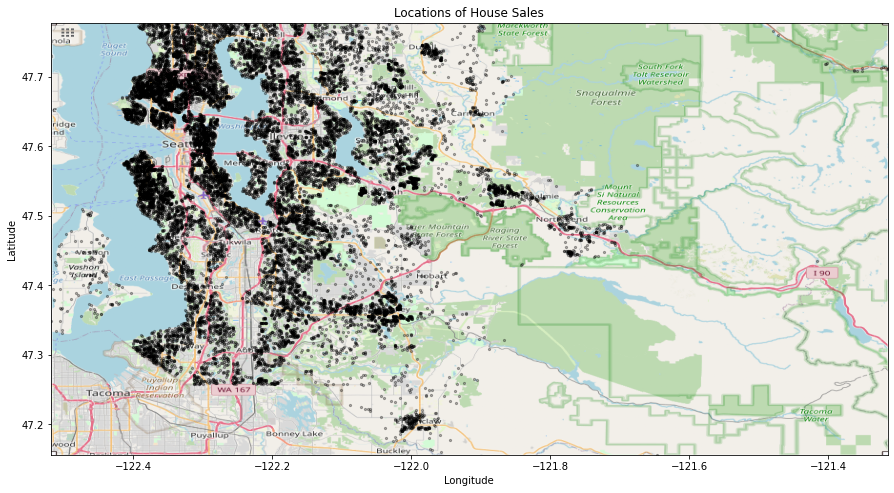

In [25]:
# Define bounding box of geographic coordinates

BBox = ((df['long'].min(),   df['long'].max(),      
         df['lat'].min(), df['lat'].max()))

# Display location data on map

fig, ax = plt.subplots(figsize=[15, 8])
df_scatter = ax.scatter(df['long'], df['lat'], zorder=1, c='k', s=5, alpha=0.3)

ax.set_title('Locations of House Sales')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
implot = ax.imshow(im, zorder=0, extent = BBox, aspect='equal')
plt.savefig('../reports/figures/Locations.png')
plt.show()

**Sale data is distributed geographically across the county, with most sales occuring on the west side of the county clustered around the Seattle metropolitan area.**

In [26]:
# Create function to plot histograms for features

def plot_hist(data, feature, fig_size=(15,8)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax = sns.histplot(data=data, x=feature)
    fig = ax.get_figure()
    return fig

In [27]:
# Create function to plot boxplots for features

def plot_box(data, feature, fig_size=(15,8)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax = sns.boxplot(data=data, x=feature)
    fig = ax.get_figure()
    return fig

In [28]:
# Create function to plot Seaborn countplots for features

def plot_count(data, feature, feature2=None, fig_size=(15,8), order=None, color=None, saturation=1):
    fig, ax = plt.subplots(figsize=fig_size)
    ax = sns.countplot(data=data, x=feature, order=order, color=color, saturation=saturation)
    fig = ax.get_figure()
    return fig

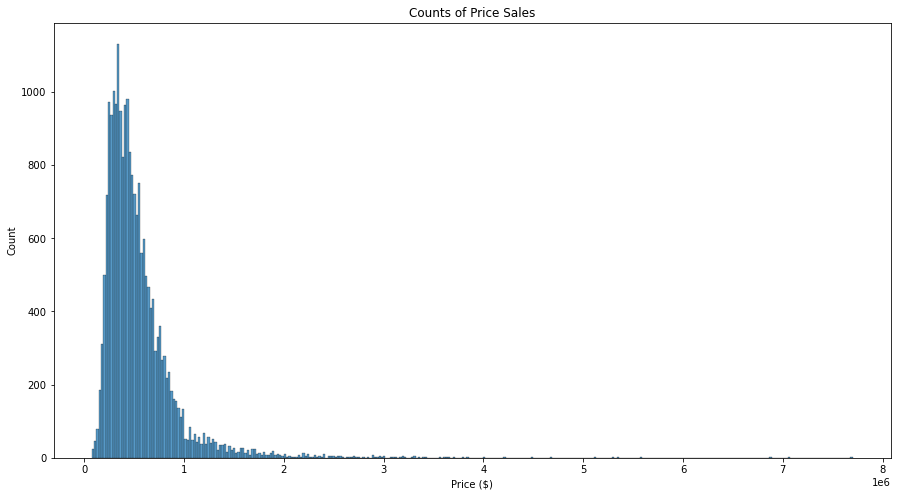

In [29]:
# Plot price histogram

plot_hist(df, 'price')
plt.title('Counts of Price Sales')
plt.xlabel('Price ($)')
plt.savefig('../reports/figures/price_count.png')
plt.show()

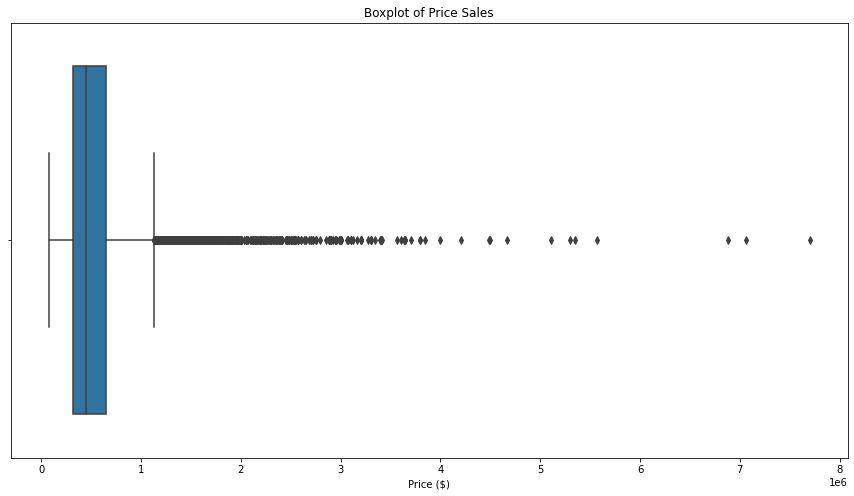

In [30]:
# Plot price boxplot

plot_box(df, 'price')
plt.title('Boxplot of Price Sales')
plt.xlabel('Price ($)')
plt.savefig('../reports/figures/price_box.png')
plt.show()

- price has a right-skewed distribution with a very long tail.
- price has many values outside of 1.5 * interquartile range (IQR). Some values are extreme outliers.

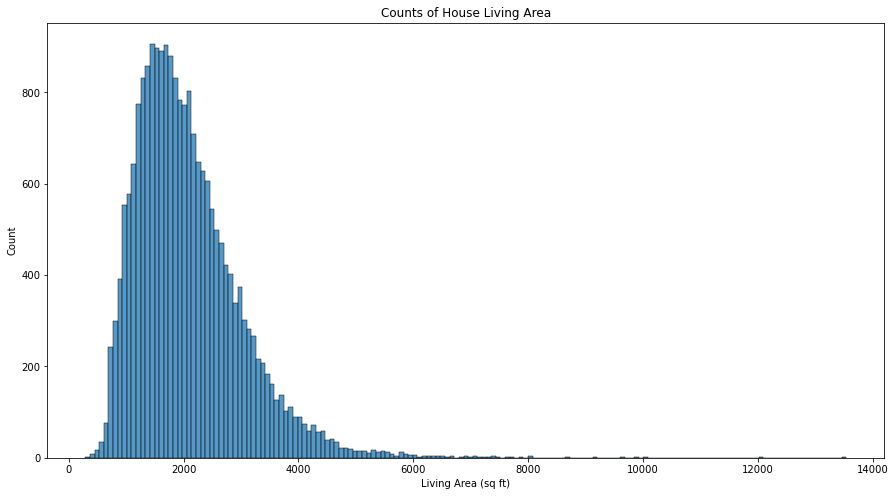

In [31]:
# Plot sqft_living histogram

plot_hist(df, 'sqft_living')
plt.title('Counts of House Living Area')
plt.xlabel('Living Area (sq ft)')
plt.savefig('../reports/figures/sqft_living_count.png')
plt.show()

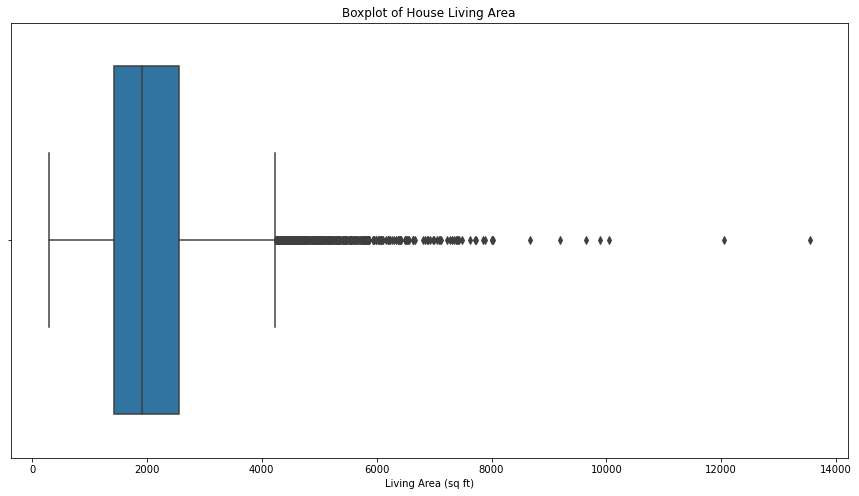

In [32]:
# Plot sqft_living boxplot

plot_box(df, 'sqft_living')
plt.title('Boxplot of House Living Area')
plt.xlabel('Living Area (sq ft)')
plt.savefig('../reports/figures/sqft_living_box.png')
plt.show()

- sqft_living has a right-skewed distribution with a long tail.
- sqft_living has many values outside of 1.5 * IQR. Some values are extreme outliers.

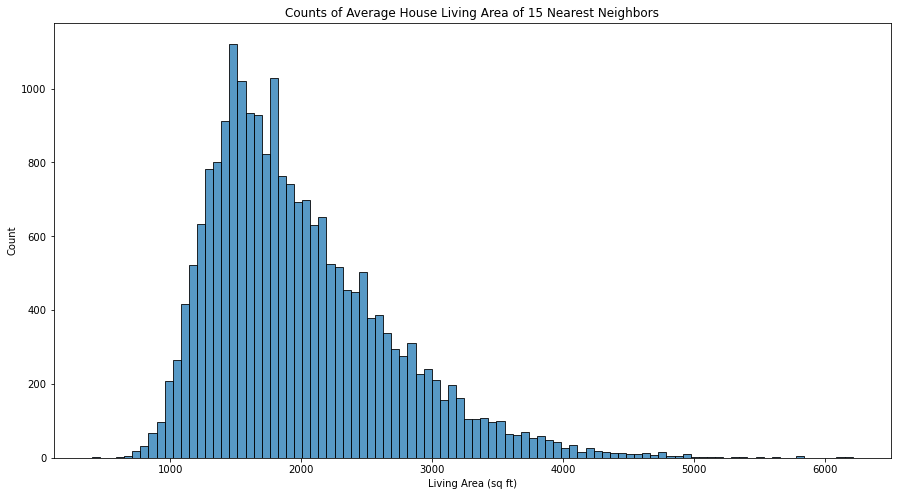

In [33]:
# Plot sqft_living15 histogram

plot_hist(df, 'sqft_living15')
plt.title('Counts of Average House Living Area of 15 Nearest Neighbors')
plt.xlabel('Living Area (sq ft)')
plt.savefig('../reports/figures/sqft_living15_count.png')
plt.show()

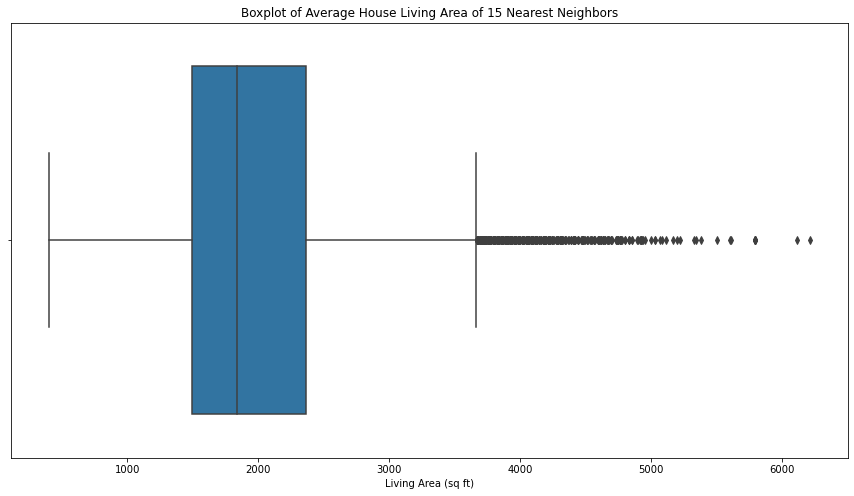

In [34]:
# Plot sqft_living15 boxplot

plot_box(df, 'sqft_living15')
plt.title('Boxplot of Average House Living Area of 15 Nearest Neighbors')
plt.xlabel('Living Area (sq ft)')
plt.savefig('../reports/figures/sqft_living15_box.png')
plt.show()

- sqft_living15 is right-skewed.
- sqft_living15 has a wider IQR and a shorter tail than sqft_living. This is intuitive as each value is an average of its 15 nearest neighbors geographically.

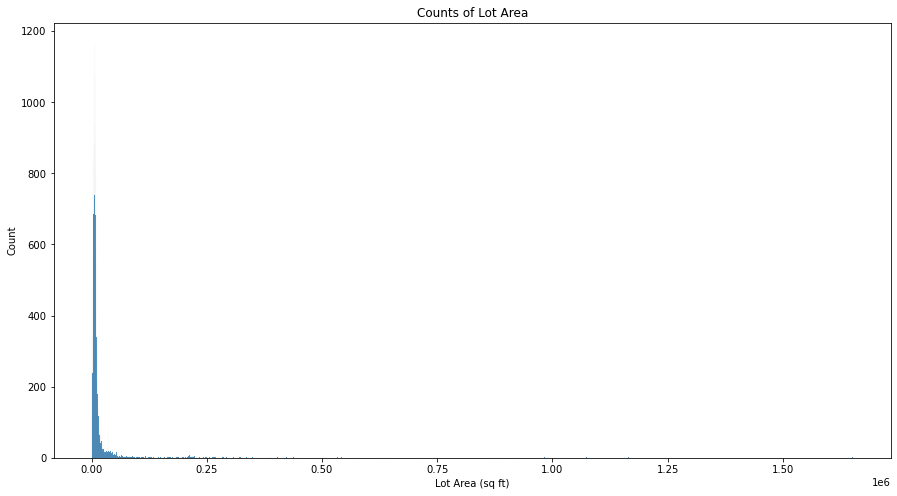

In [35]:
# Plot sqft_lot histogram

plot_hist(df, 'sqft_lot')
plt.title('Counts of Lot Area')
plt.xlabel('Lot Area (sq ft)')
plt.savefig('../reports/figures/sqft_lot_count.png')
plt.show()

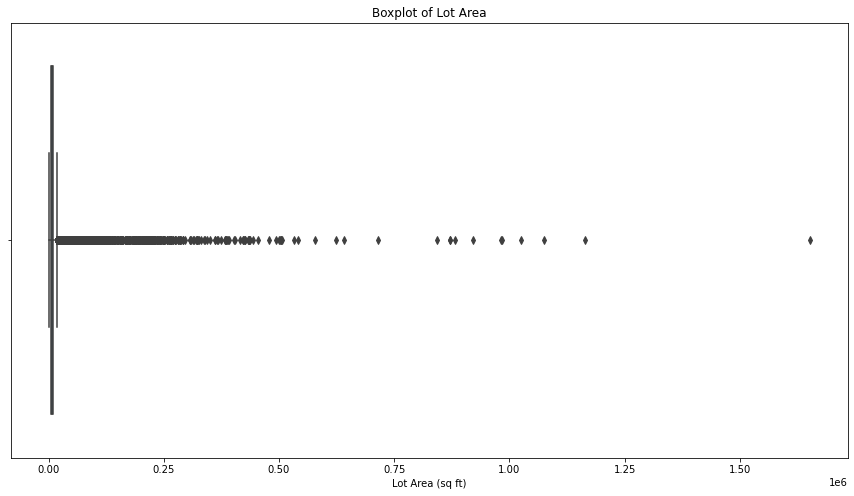

In [36]:
# Plot sqft_lot boxplot
plot_box(df, 'sqft_lot')
plt.title('Boxplot of Lot Area')
plt.xlabel('Lot Area (sq ft)')
plt.savefig('../reports/figures/sqft_lot_box.png')
plt.show()

sqft_lot has an extremely long tail and is right-skewed. Some lots are very large and likely in more rural parts of the county relative to small urban lots close to Seattle. 

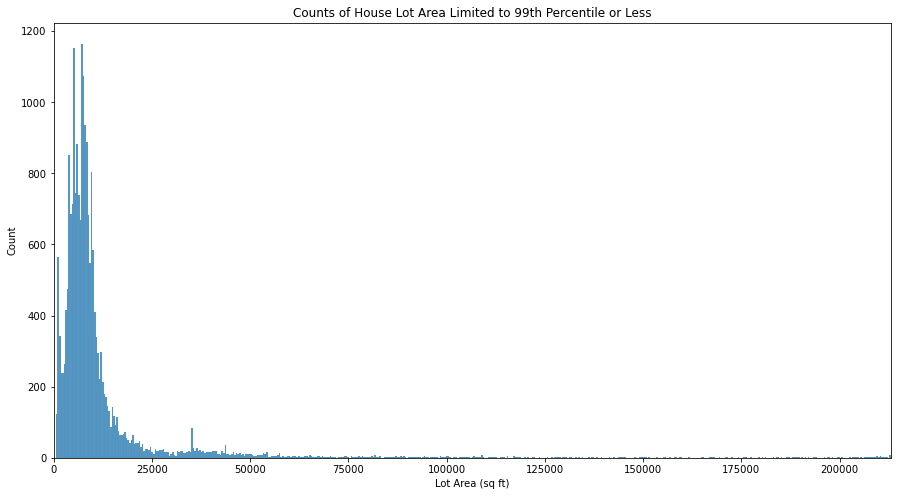

In [37]:
# Plot sqft_lot histogram limited to 99th percentile to a get a better view of data shape

plot_hist(df, 'sqft_lot')
plt.xlim(0,np.percentile(df['sqft_lot'], 99))
plt.title('Counts of House Lot Area Limited to 99th Percentile or Less')
plt.xlabel('Lot Area (sq ft)')
plt.savefig('../reports/figures/sqft_lot99th_count.png')
plt.show()

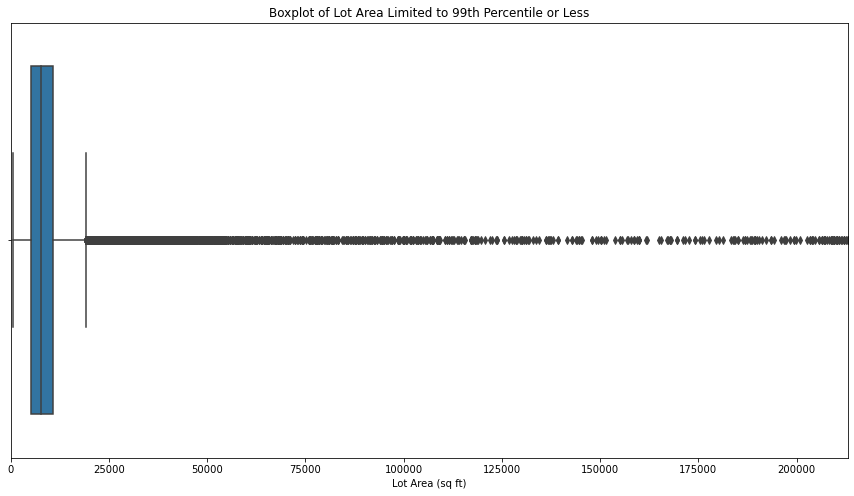

In [38]:
# Plot sqft_lot boxplot limited to 99th percentile to a get a better view of data shape

plot_box(df, 'sqft_lot')
plt.xlim(0,np.percentile(df['sqft_lot'], 99))
plt.title('Boxplot of Lot Area Limited to 99th Percentile or Less')
plt.xlabel('Lot Area (sq ft)')
plt.savefig('../reports/figures/sqft_lot99th_box.png')
plt.show()

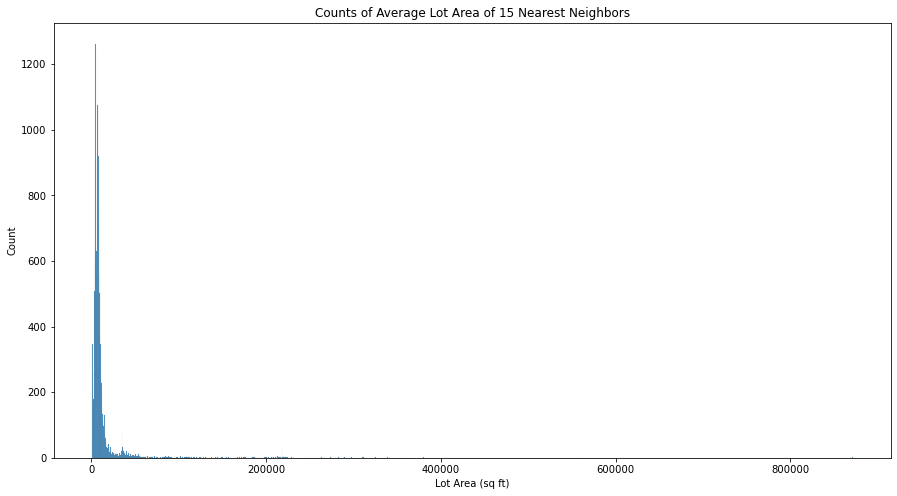

In [39]:
# Plot sqft_lot15 histogram

plot_hist(df, feature='sqft_lot15')
plt.title('Counts of Average Lot Area of 15 Nearest Neighbors')
plt.xlabel('Lot Area (sq ft)')
plt.savefig('../reports/figures/sqft_lot15_count.png')
plt.show()

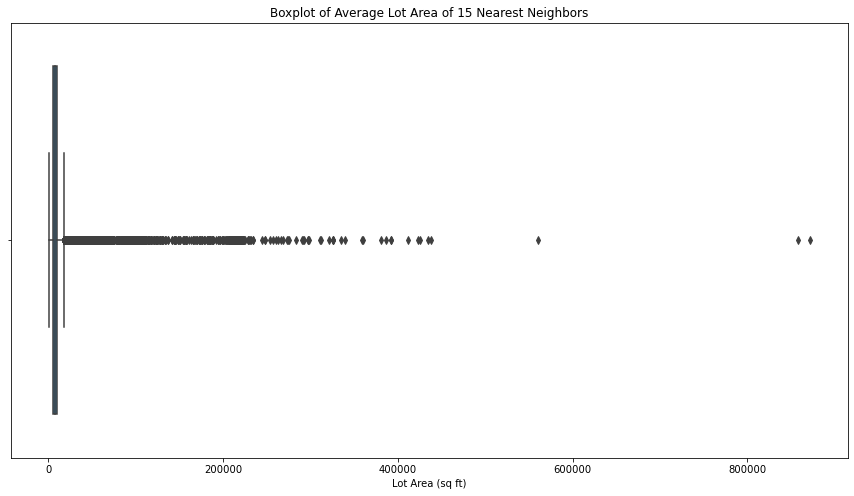

In [40]:
# Plot sqft_lot15 boxplot

plot_box(df, 'sqft_lot15')
plt.title('Boxplot of Average Lot Area of 15 Nearest Neighbors')
plt.xlabel('Lot Area (sq ft)')
plt.savefig('../reports/figures/sqft_lot15_box.png')
plt.show()

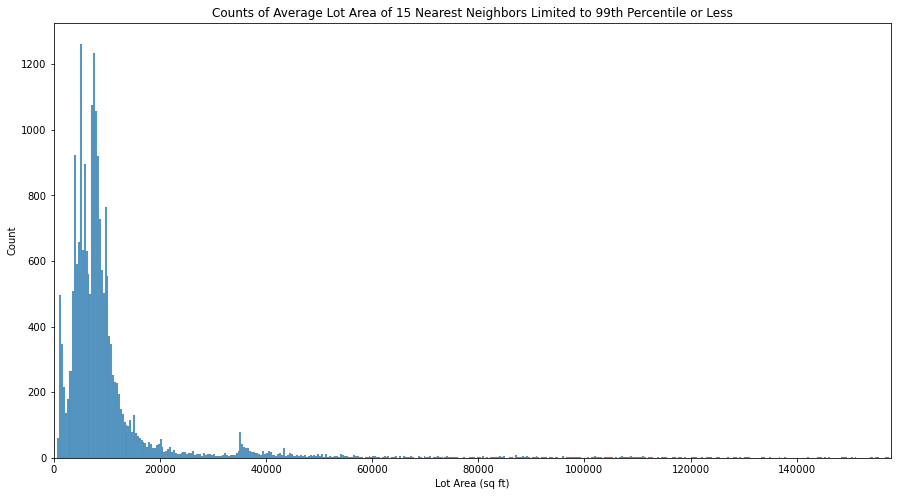

In [41]:
# Plot sqft_lot15 histogram limited to 99th percentile to a get a better view of data shape

plot_hist(df, 'sqft_lot15')
plt.xlim(0,np.percentile(df['sqft_lot15'], 99))
plt.title('Counts of Average Lot Area of 15 Nearest Neighbors Limited to 99th Percentile or Less')
plt.xlabel('Lot Area (sq ft)')
plt.savefig('../reports/figures/sqft_lot15_99th_count.png')
plt.show()

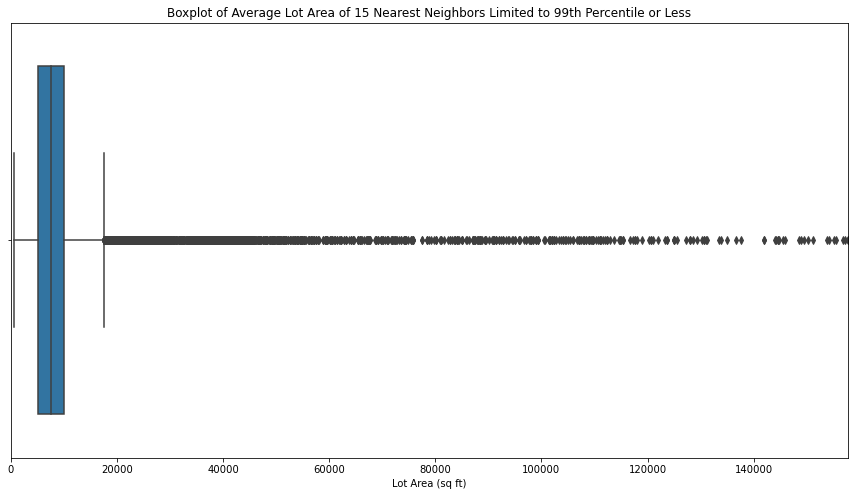

In [42]:
# Plot sqft_lot boxplot limited to 99th percentile to a get a better view of data shape

plot_box(df, 'sqft_lot15')
plt.xlim(0,np.percentile(df['sqft_lot15'], 99))
plt.title('Boxplot of Average Lot Area of 15 Nearest Neighbors Limited to 99th Percentile or Less')
plt.xlabel('Lot Area (sq ft)')
plt.savefig('../reports/figures/sqft_lot15_99th_box.png')
plt.show()

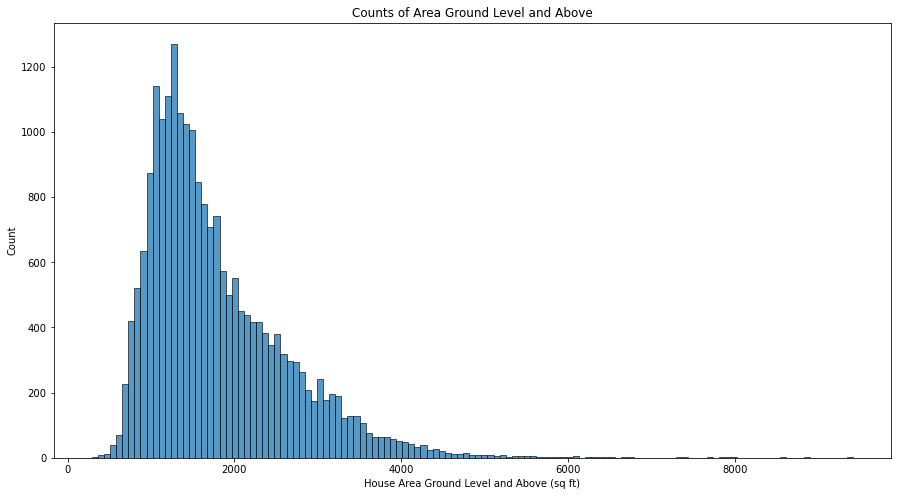

In [43]:
# Plot sqft_above histogram

plot_hist(df, feature='sqft_above')
plt.title('Counts of Area Ground Level and Above')
plt.xlabel('House Area Ground Level and Above (sq ft)')
plt.savefig('../reports/figures/sqft_above_count.png')
plt.show()

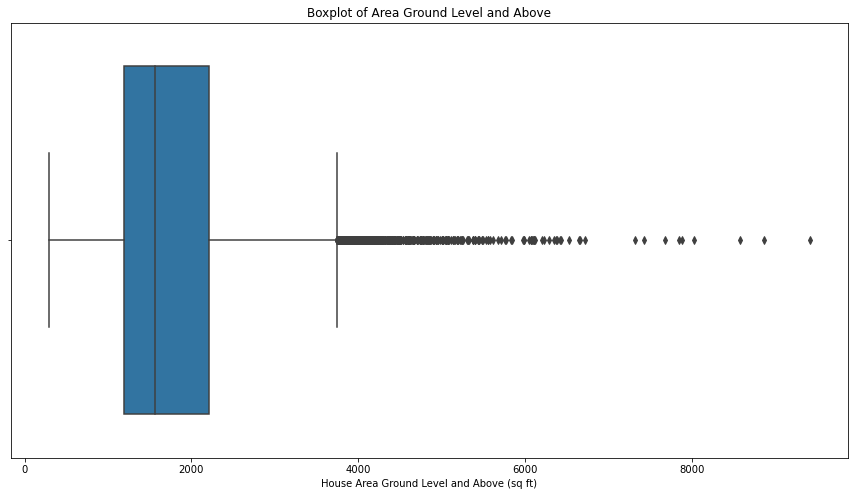

In [44]:
# Plot sqft_above boxplot

plot_box(df, 'sqft_above')
plt.title('Boxplot of Area Ground Level and Above')
plt.xlabel('House Area Ground Level and Above (sq ft)')
plt.savefig('../reports/figures/sqft_above_box.png')
plt.show()

sqft_above is right-skewed and has a wider IQR than sqft_living.

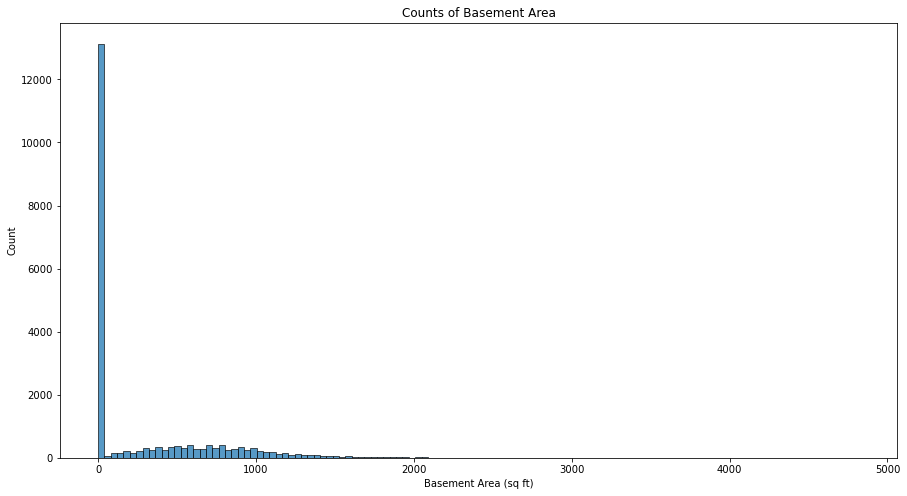

In [45]:
# Plot sqft_basement histogram

plot_hist(df, feature='sqft_basement')
plt.title('Counts of Basement Area')
plt.xlabel('Basement Area (sq ft)')
plt.savefig('../reports/figures/sqft_basement_count.png')
plt.show()

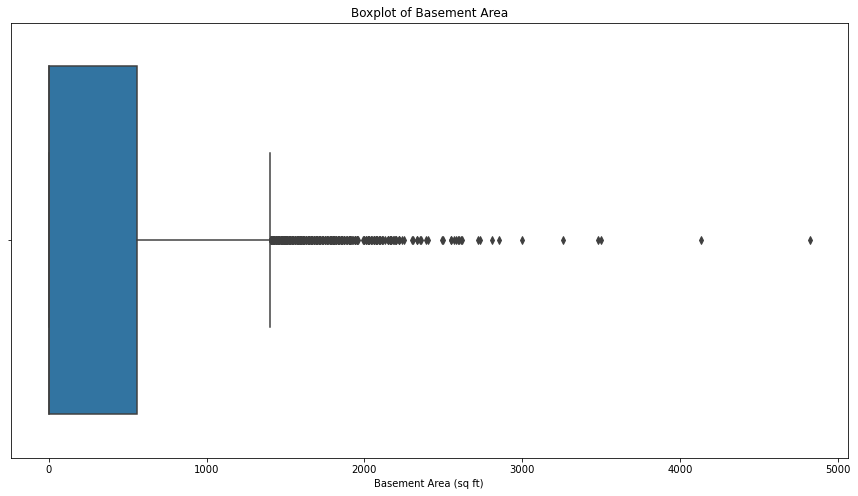

In [46]:
# Plot sqft_basement boxplot

plot_box(df, 'sqft_basement')
plt.title('Boxplot of Basement Area')
plt.xlabel('Basement Area (sq ft)')
plt.savefig('../reports/figures/sqft_basement_box.png')
plt.show()

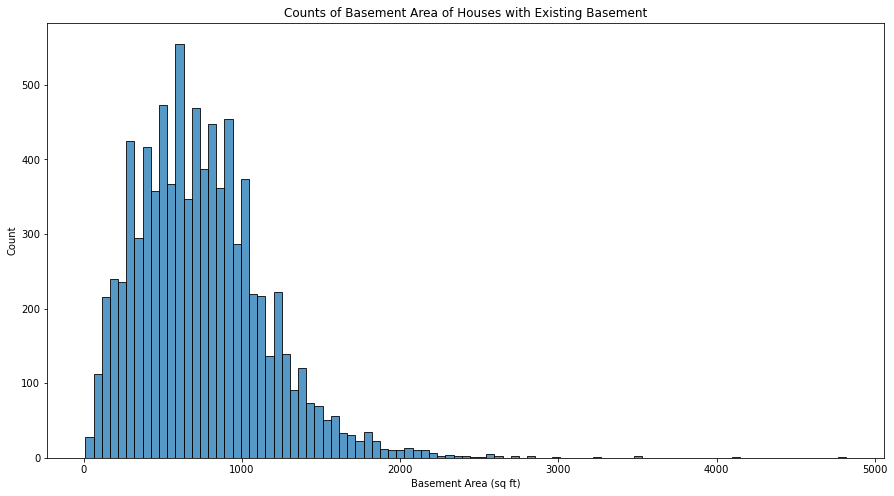

In [47]:
# Plot histogram of basement area where sqft_basement value != 0

base = df[df['sqft_basement'] != 0]

plot_hist(base, feature='sqft_basement')
plt.title('Counts of Basement Area of Houses with Existing Basement')
plt.xlabel('Basement Area (sq ft)')
plt.savefig('../reports/figures/sqft_basement_exists_count.png')
plt.show()

In [48]:
# Calculate percentage of sales without a basement

print('Approximately', round(df[df['sqft_basement'] == 0]['sqft_basement'].count() / df['sqft_basement'].count() * 100), '% of house sales lack a basement.')

Approximately 61 % of house sales lack a basement.


For the properties that do have a basement, the sqft_basement measurement is right-skewed with a long tail like many features in this dataset.

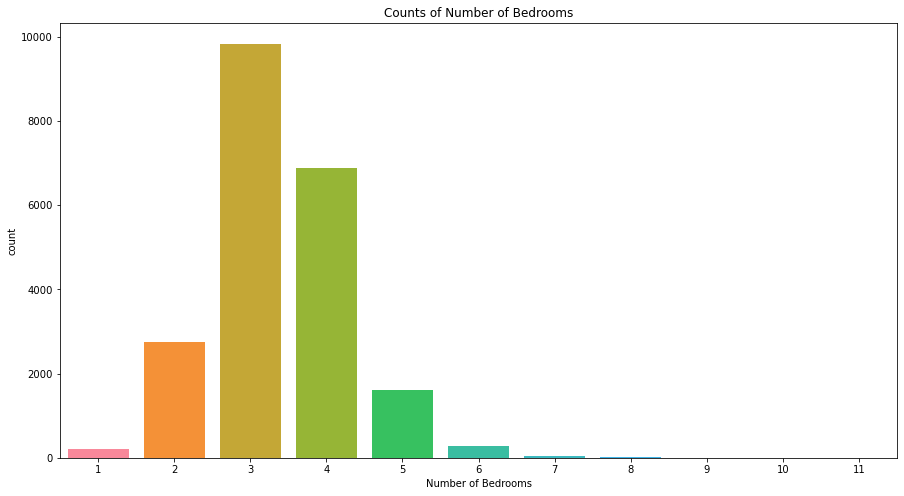

In [49]:
# Plot bedrooms countplot (discrete variables look neater with Seaborn countplot as opposed to histogram)

plot_count(df, 'bedrooms')
plt.title('Counts of Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.savefig('../reports/figures/bedrooms_count.png')
plt.show()

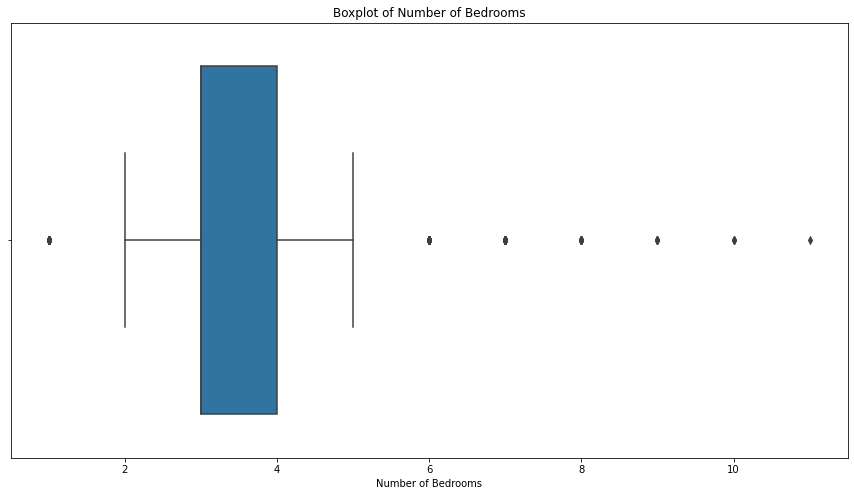

In [50]:
# Plot bedrooms boxplot

plot_box(df, 'bedrooms')
plt.title('Boxplot of Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.savefig('../reports/figures/bedrooms_box.png')
plt.show()

After changing the value 33 bedroom value to 3, the bedroom distribution looks more reasonable. It is also right skewed, with bedroom values 6 and above lying outside 1.5 * IQR.

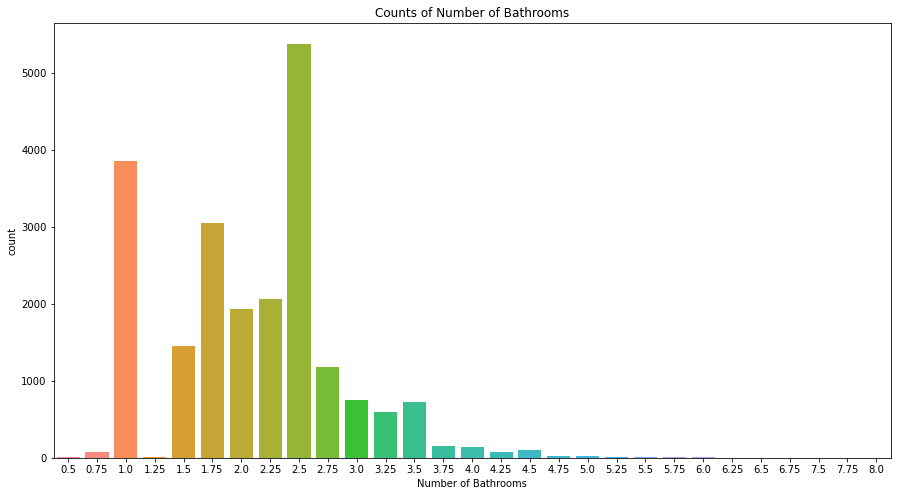

In [51]:
# Plot bathrooms countplot

plot_count(df, 'bathrooms')
plt.title('Counts of Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.savefig('../reports/figures/bathrooms_count.png')
plt.show()

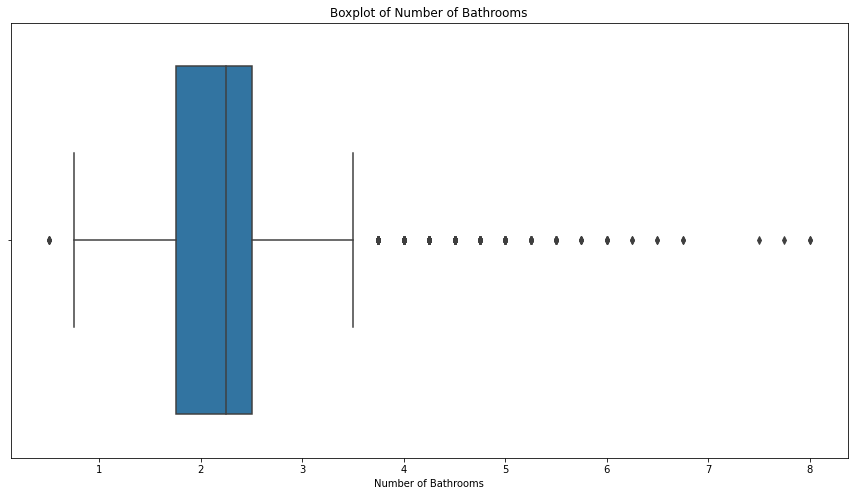

In [52]:
# Plot bathrooms boxplot

plot_box(df, 'bathrooms')
plt.title('Boxplot of Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.savefig('../reports/figures/bathrooms_box.png')
plt.show()

The bathrooms distribution is bimodal, with many homes having only 1 bathroom. 2.5 bathrooms is the most common value for all homes.

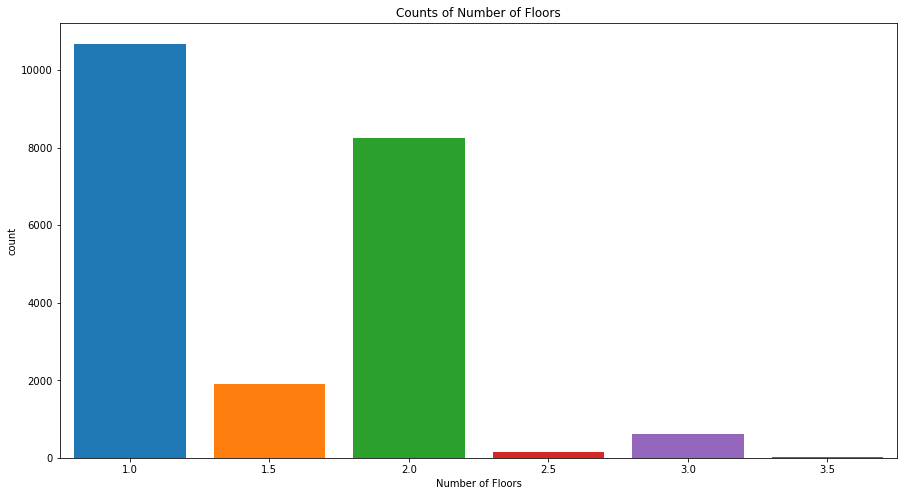

In [53]:
# Plot floors countplot

plot_count(df, 'floors')
plt.title('Counts of Number of Floors')
plt.xlabel('Number of Floors')
plt.savefig('../reports/figures/floors_count.png')
plt.show()

The floors distibution is bimodal. Most homes have 1 or 2 floors.

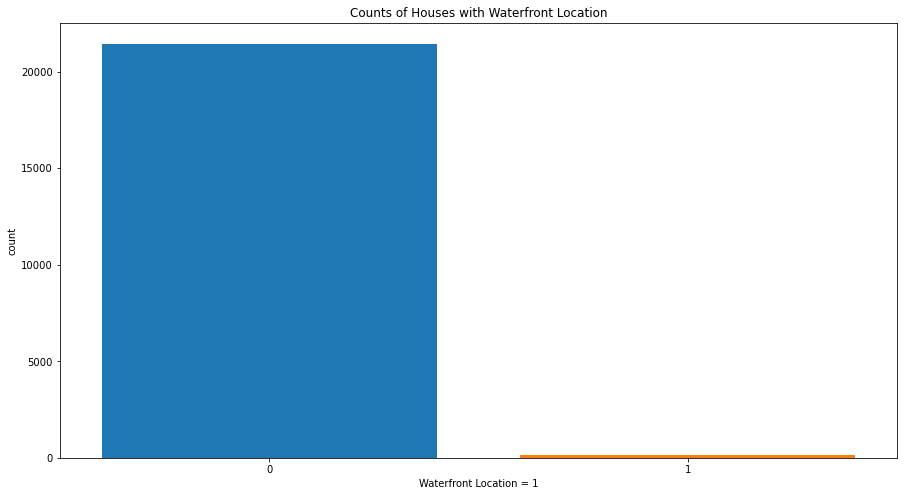

In [54]:
# Plot waterfront countplot

plot_count(df, 'waterfront')
plt.title('Counts of Houses with Waterfront Location')
plt.xlabel('Waterfront Location = 1')
plt.savefig('../reports/figures/waterfront_count.png')
plt.show()

In [55]:
df['waterfront'].value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

Only 163 house sales were waterfront properties.

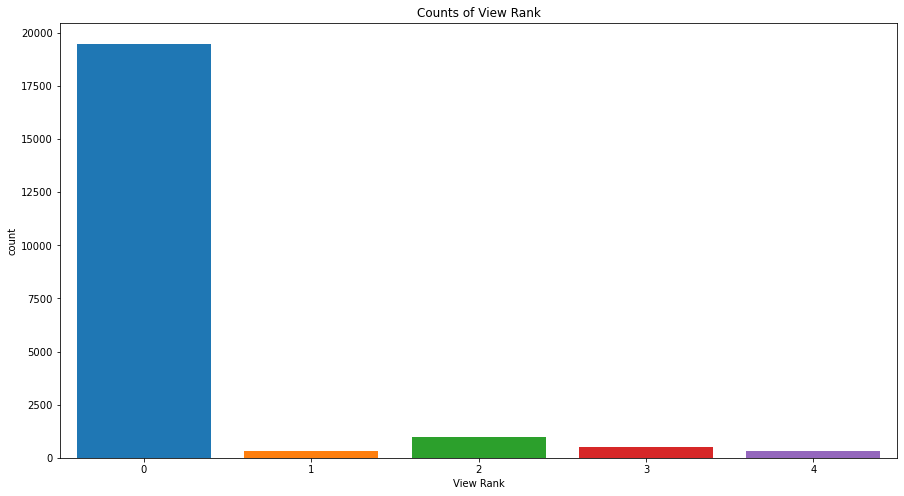

In [56]:
# Plot view countplot

plot_count(df, 'view')
plt.title('Counts of View Rank')
plt.xlabel('View Rank')
plt.savefig('../reports/figures/view_count.png')
plt.show()

In [57]:
df['view'].value_counts()

0    19489
2      963
3      510
1      332
4      319
Name: view, dtype: int64

In [58]:
print('Approximately', round(df[df['view'] == 0]['view'].count() / df['view'].count() * 100), '% of sales have a view value of zero.')

Approximately 90 % of sales have a view value of zero.


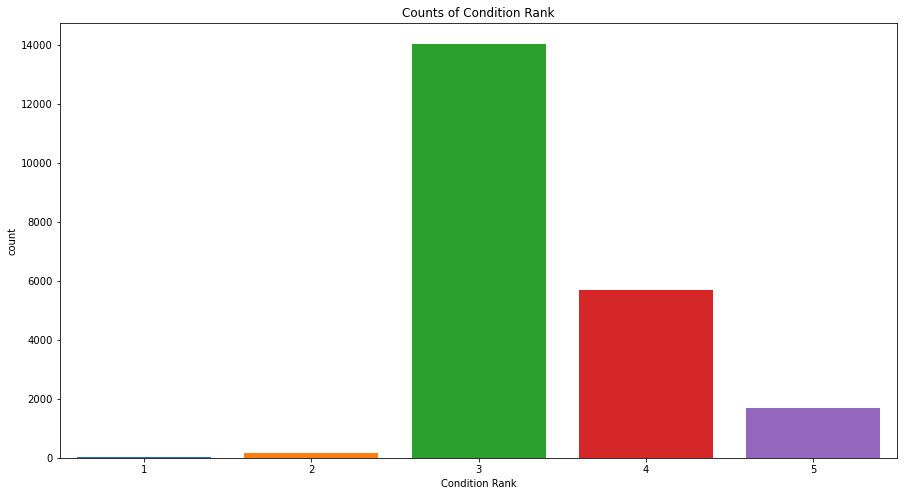

In [59]:
# Plot condition countplot

plot_count(df, 'condition')
plt.title('Counts of Condition Rank')
plt.xlabel('Condition Rank')
plt.savefig('../reports/figures/condition_count.png')
plt.show()

Condition is left-skewed, with most sales have a condition value of 3.

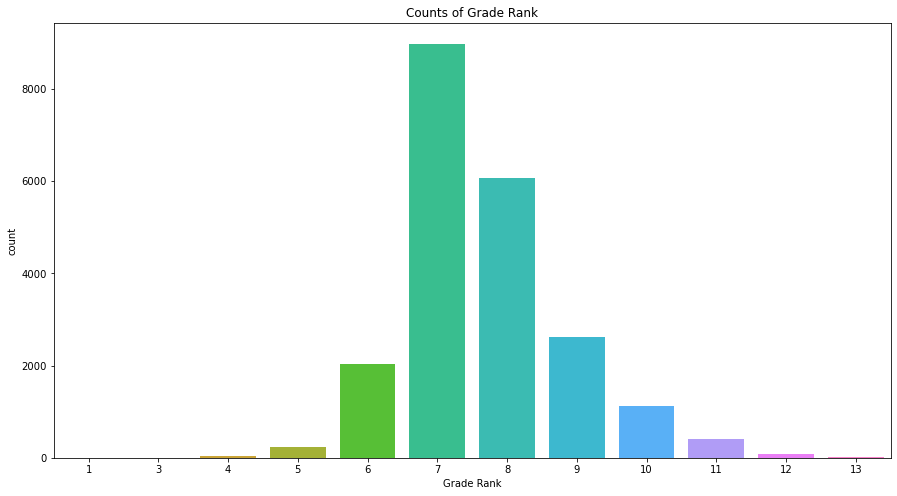

In [60]:
# Plot grade countplot

plot_count(df, 'grade')
plt.title('Counts of Grade Rank')
plt.xlabel('Grade Rank')
plt.savefig('../reports/figures/grade_count.png')
plt.show()

In [61]:
df['grade'].astype(int).median()

7.0

The median value of grade is 7. The distribution of grade is slightly right-skewed.

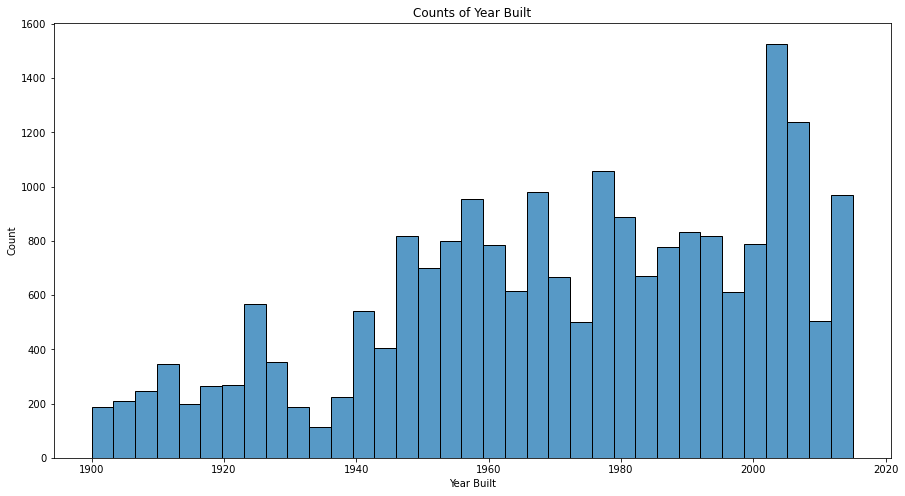

In [62]:
# Plot yr_built countplot

plot_hist(df, 'yr_built')
plt.title('Counts of Year Built')
plt.xlabel('Year Built')
plt.savefig('../reports/figures/year_built_count.png')
plt.show()

Counts tend to increase as yr_built increases.

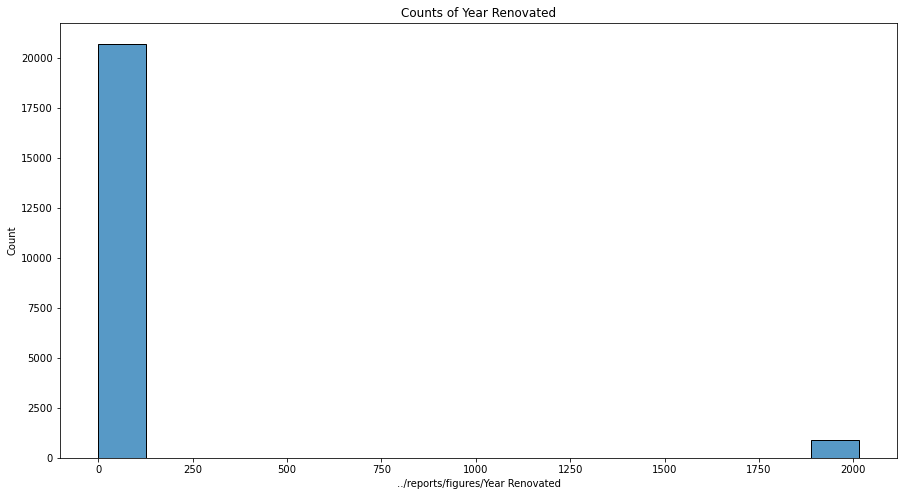

In [63]:
# Plot yr_built countplot

plot_hist(df, 'yr_renovated')
plt.title('Counts of Year Renovated')
plt.xlabel('../reports/figures/Year Renovated')
plt.show()

In [64]:
df[df['yr_renovated'] == 0]['yr_renovated'].count()

print('Approximately', round(df[df['yr_renovated'] == 0]['yr_renovated'].count() / df['yr_renovated'].count() * 100), '% of sales have a yr_renovated value of zero.')

Approximately 96 % of sales have a yr_renovated value of zero.


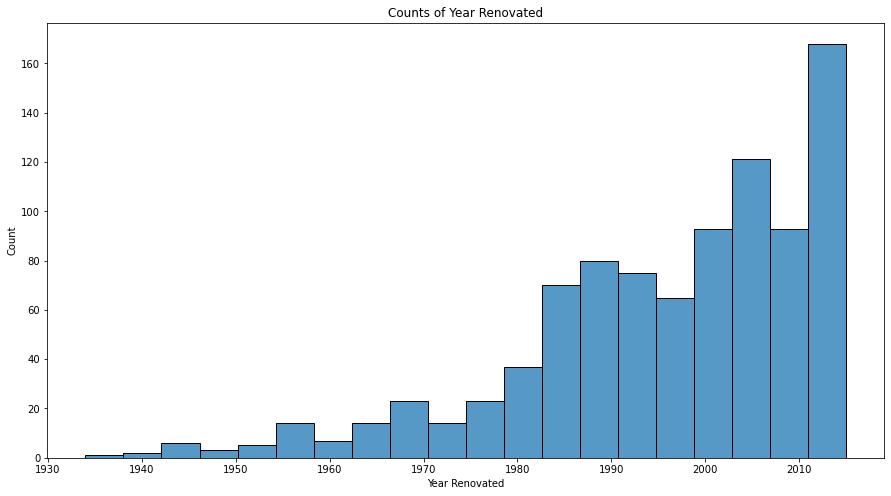

In [65]:
# Plot counts of year renovated where yr_renovated != 0
reno = df[df['yr_renovated'] != 0]
plot_hist(reno, 'yr_renovated')
plt.title('Counts of Year Renovated')
plt.xlabel('Year Renovated')
plt.savefig('../reports/figures/year_renovated_count.png')
plt.show()

In [66]:
reno['yr_renovated'].count()

914

Of the 914 house sales that were renovated homes, renovations tend to happen in more recent years.

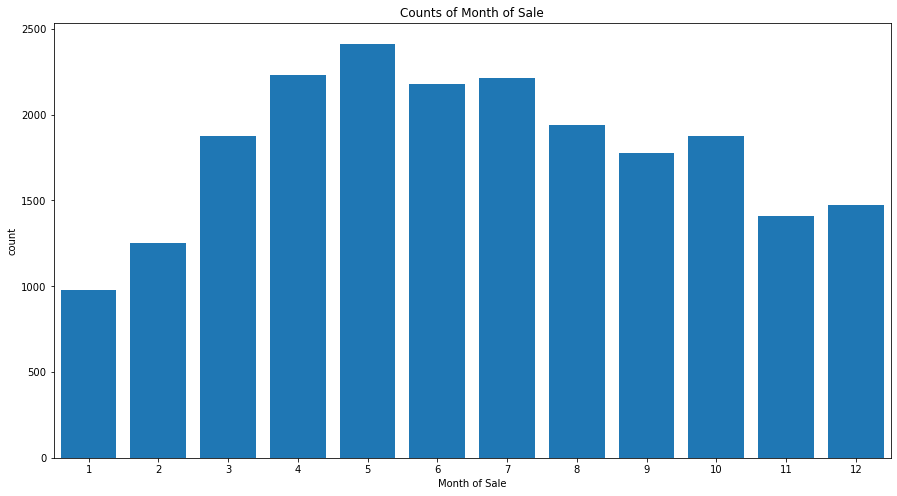

In [67]:
# Plot counts of month of sale

month = df.copy()
month['month'] = df['date'].dt.month
plot_count(month, 'month', color='tab:blue')
plt.title('Counts of Month of Sale')
plt.xlabel('Month of Sale')
plt.savefig('../reports/figures/month_count.png')
plt.show()

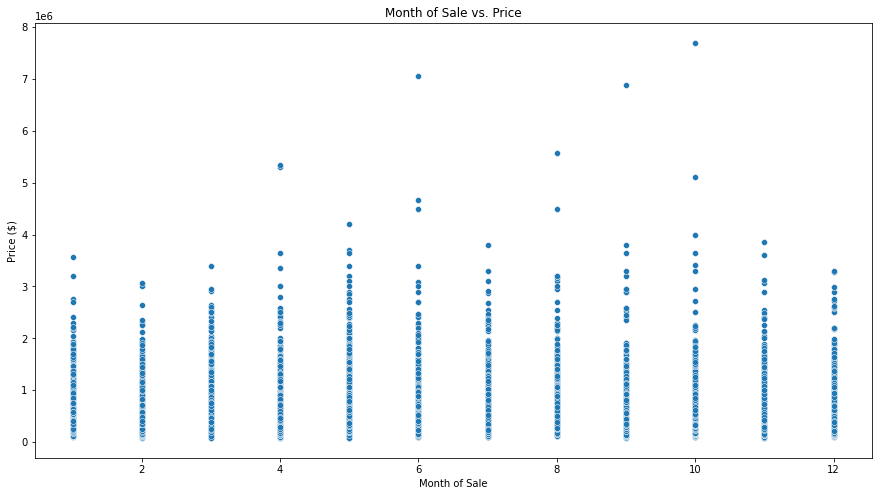

In [68]:
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data=month, x='month', y='price')
plt.title('Month of Sale vs. Price')
plt.xlabel('Month of Sale')
plt.ylabel('Price ($)')
plt.savefig('../reports/figures/month_vs_price.png')
plt.show()

**There appears to be a relatively weak relationship between month sold and sale price.**

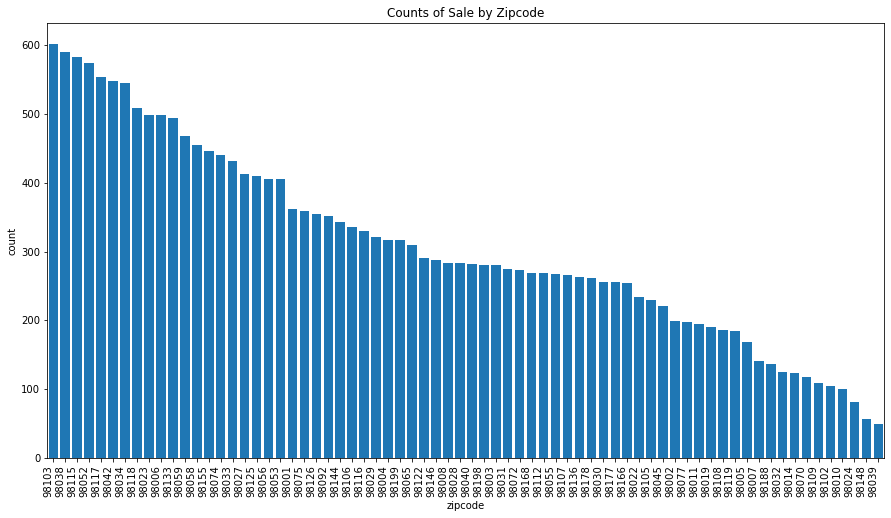

In [69]:
# Plot counts of zipcode ordered descending

plot_count(df, 'zipcode', order=df['zipcode'].value_counts().index, color='tab:blue', saturation=1)
plt.xticks(rotation=90, ha='right')
plt.title('Counts of Sale by Zipcode')
plt.savefig('../reports/figures/zipcode_sales.png')
plt.show()

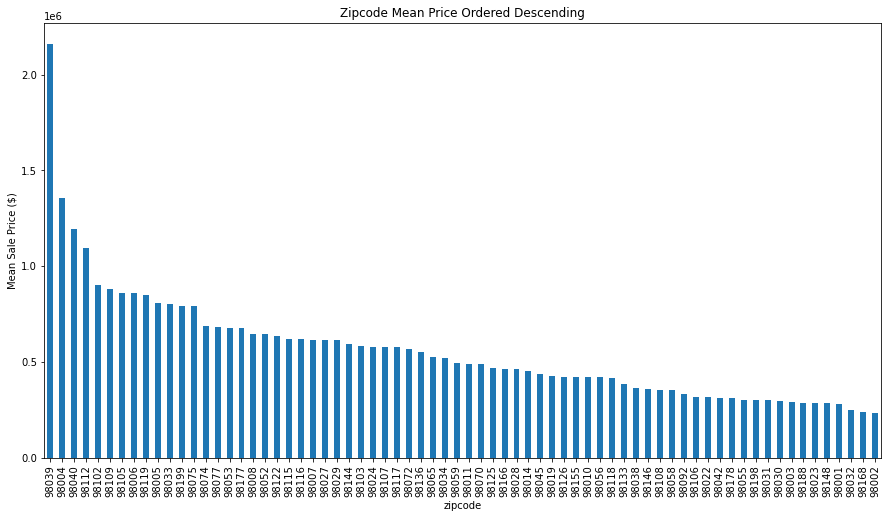

In [70]:
# Plot mean price by zipcode ordered descending

fig, ax = plt.subplots(figsize=[15,8])
df.groupby(by='zipcode').mean()['price'].sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Mean Sale Price ($)')
plt.title('Zipcode Mean Price Ordered Descending')
plt.savefig('../reports/figures/zipcode_mean_price.png')
plt.show()

There are a 4 zipcodes that stand out above the others with respect to mean sale price (zipcodes 98039, 98004, 98040, 98112). One thing to note is that the zipcode with the highest mean sale price (zipcode 98039) also had the fewest sales. The zipcode with the highest count of sales (zipcode 98103) has a mean sale price near the middle of the range.

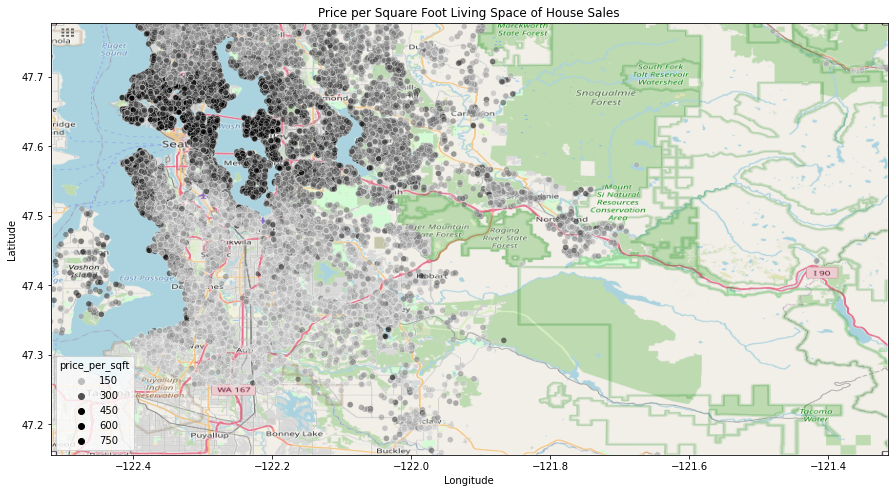

In [71]:
# Plot price per square foot living space

price_df = df.copy()
price_df['price_per_sqft'] = price_df['price'] / price_df['sqft_living']

fig, ax = plt.subplots(figsize=[15, 8])
sns.scatterplot(data=price_df, x='long', y='lat', palette='Greys', hue='price_per_sqft', zorder=1, alpha=0.5, hue_norm=(0,400))
ax.set_title('Price per Square Foot Living Space of House Sales')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
implot = ax.imshow(im, zorder=0, extent = BBox, aspect='equal')
plt.savefig('../reports/figures/price_per_sqft.png')
plt.show()

**Price per square foot is highest around Seattle.**

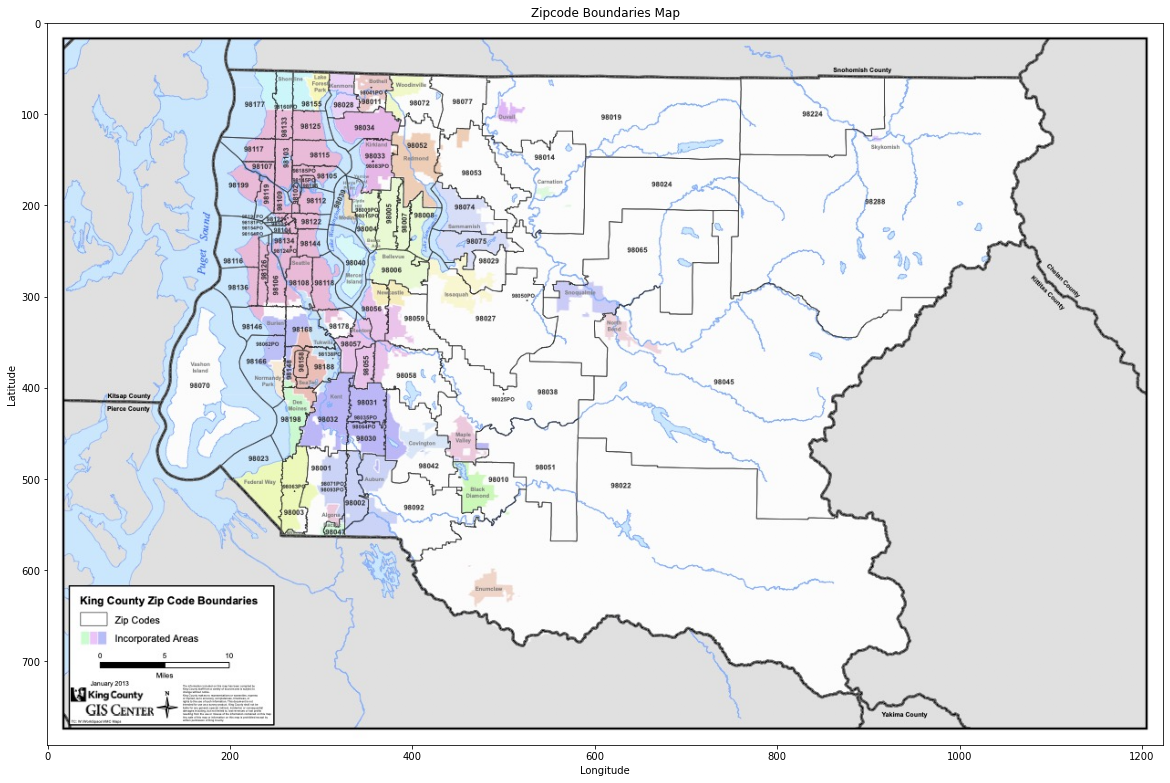

In [72]:
# Show image of zipcode boundaries

fig, ax = plt.subplots(figsize=[20, 20])

im2 = plt.imread('../zipcodes_KingCounty_WA.png')
ax.set_title('Zipcode Boundaries Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
implot = ax.imshow(im2)
plt.show()

**zipcode is an important proxy to represent geographic location of a house sale.**

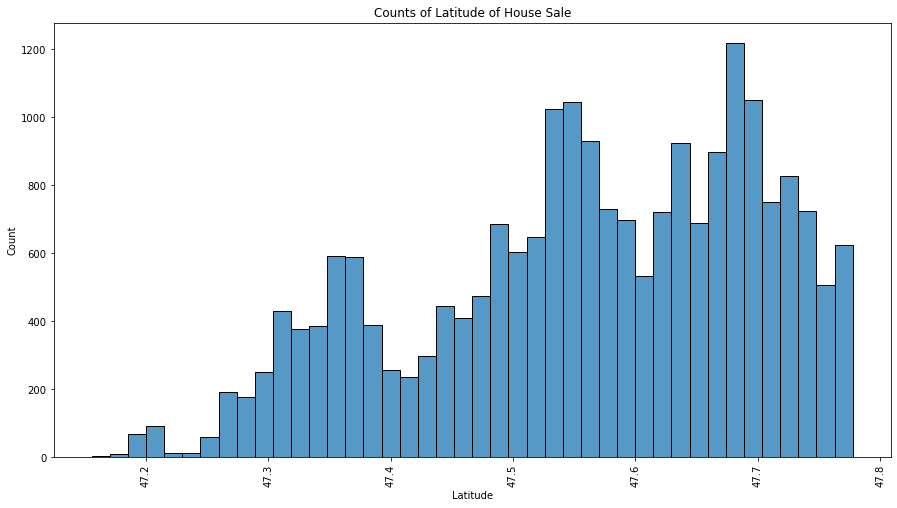

In [73]:
# Plot counts of lat

plot_hist(df, 'lat')
plt.xticks(rotation=90)
plt.title('Counts of Latitude of House Sale')
plt.xlabel('Latitude')
plt.savefig('../reports/figures/lat_count.png')
plt.show()

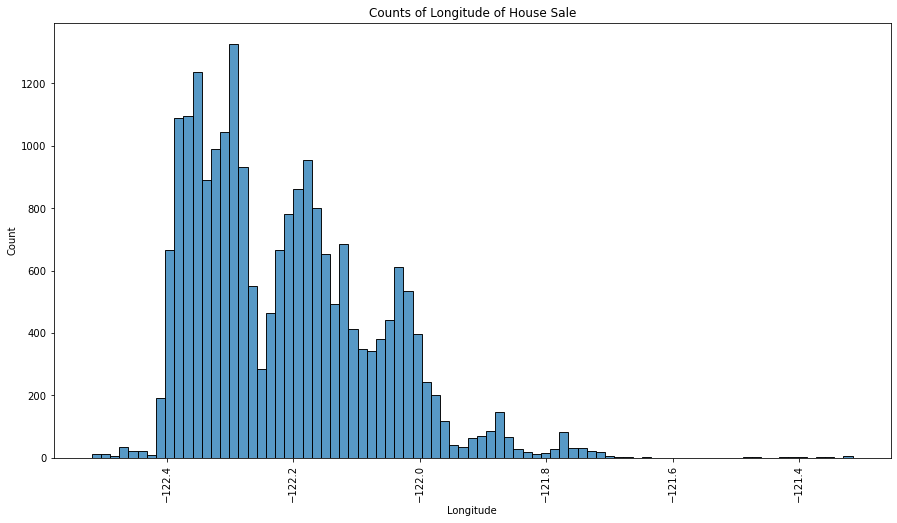

In [74]:
# Plot counts of long

plot_hist(df, 'long')
plt.xticks(rotation=90)
plt.title('Counts of Longitude of House Sale')
plt.xlabel('Longitude')
plt.savefig('../reports/figures/long_count.png')
plt.show()

House sales are clustered along certain latitude and longitude values. Few sales occurred east of longitude -121.6.

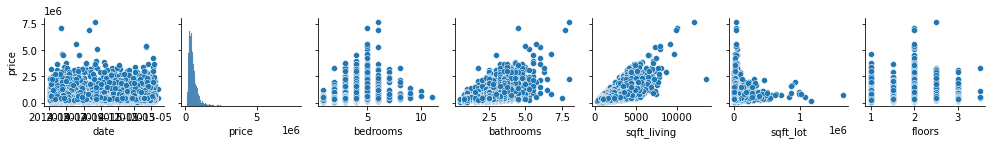

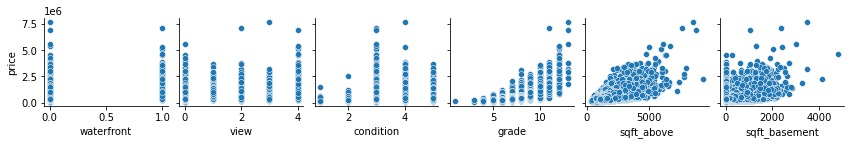

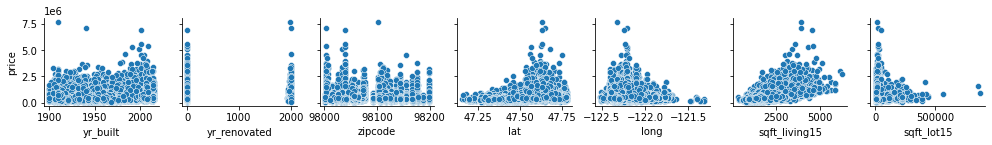

In [75]:
# Generate pairplots with price on y-axis

sns.pairplot(data=df, y_vars='price', x_vars=df.columns[1:8], height=2)
plt.savefig('../reports/figures/Pairplot1.png')

sns.pairplot(data=df, y_vars='price', x_vars=df.columns[8:14], height=2)
plt.savefig('../reports/figures/Pairplot2.png')

sns.pairplot(data=df, y_vars='price', x_vars=df.columns[14:], height=2)
plt.savefig('../reports/figures/Pairplot3.png')
plt.show()

- There appear to be linear trends between price and bedrooms, bathrooms, sqft_living, sqft_above, sqft_basement, sqft_living15.

- Non-linear correlations with price include sqft_lot, sqft_lot15, grade, lat, long.

In [76]:
# Use pandas method .corr() to calculate the Pearson correlation coefficients

df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016762,0.002522,0.005237,-0.012258,-0.132109,0.018525,-0.002721,0.011592,-0.023783,0.008130,-0.010842,-0.005151,0.021380,-0.016907,-0.008224,-0.001891,0.020799,-0.002901,-0.138798
price,-0.016762,1.000000,0.316028,0.525714,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.002522,0.316028,1.000000,0.527471,0.593099,0.033381,0.183571,-0.006811,0.082464,0.023806,0.366381,0.492432,0.309434,0.160708,0.019282,-0.158167,-0.011302,0.135349,0.404439,0.031507
bathrooms,0.005237,0.525714,0.527471,1.000000,0.755327,0.087931,0.502167,0.063737,0.188357,-0.126260,0.664578,0.686289,0.283373,0.506910,0.050543,-0.204855,0.024222,0.225015,0.569452,0.087551
sqft_living,-0.012258,0.702035,0.593099,0.755327,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,-0.132109,0.089661,0.033381,0.087931,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.018525,0.256794,0.183571,0.502167,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,-0.002721,0.266369,-0.006811,0.063737,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.011592,0.397293,0.082464,0.188357,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,-0.023783,0.036362,0.023806,-0.126260,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406


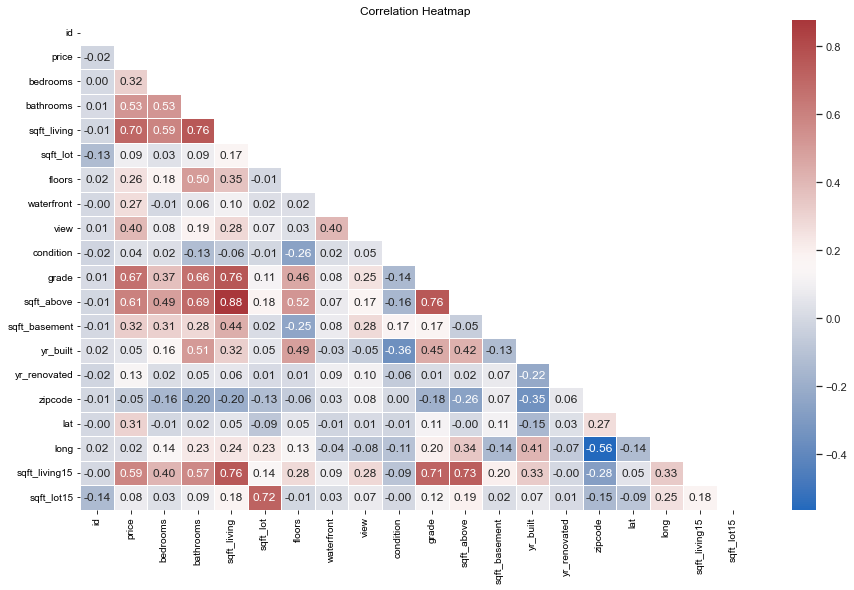

In [77]:
# Generate heatmap showing Pearson correlation coefficients

fig, ax = plt.subplots(figsize=(15, 9))
sns.set(font_scale=1)

# create mask for upper triangle

mask = np.triu(np.ones_like(df.corr()))

sns.heatmap(data=df.corr(), annot=True, linewidths=0.5, cmap='vlag', fmt='0.2f',
           mask=mask).set(title='Correlation Heatmap')

plt.savefig('../reports/figures/corr_heatmap.png')
plt.show()

- sqft_living, grade, sqft_above, sqft_living15, bathrooms are the highest correlated features with price.

- sqft_lot and sqft_lot15 do not appear to have linear relationships with price.

- Many features are correlated with one another.

- bedrooms has a low to moderate correlation with price.

## Pre-processing and Feature Engineering

In [78]:
# Set y to price values

y = df['price']

In [79]:
y

0        221900
1        538000
2        180000
3        604000
4        510000
          ...  
21608    360000
21609    400000
21610    402101
21611    400000
21612    325000
Name: price, Length: 21613, dtype: int64

### Create Features

In [80]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [81]:
# Make binary features for 'yr_renovated', 'view', 'sqft_basement'

df['renovated'] = 0
df.loc[df['yr_renovated'] != 0, 'renovated'] = 1

df['basement'] = 0
df.loc[df['sqft_basement'] != 0, 'basement'] = 1

df['view_binary'] = 0
df.loc[df['view'] != 0, 'view_binary'] = 1

In [82]:
# Make feature for month sold

df['month'] = df['date'].dt.month

In [83]:
# Create bins for age of house by decade

bins = np.append(np.linspace(df['yr_built'].min(), 2010, 12), 2015)
bins

# Create labels

labels = ['1900s', '1910s', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

# Create age feature and cut data into bins

df['decade_built'] = pd.cut(df['yr_built'], bins=bins, labels=labels, include_lowest=True)

**sqft_above is being dropped due to being highly correlated (multicollinear) to sqft_living. sqft_basement, yr_built, yr_renovated will be dropped after features were created to represent these. Lat and long will be dropped, since geographic location of sale is being represented by Zip Code. sqft_living15 and sqft_lot15 will be dropped due to multicollinearity with sqft_living and sqft_lot, and because this is an engineered feature of unknown origin/calculation, not original data.**

In [84]:
# Set X to remaining DataFrame values and drop unused features

X = df.drop(columns=['id', 'date', 'price', 'view', 'sqft_above', 'sqft_basement', 'yr_built',
                     'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15'])

In [85]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'zipcode', 'renovated', 'basement',
       'view_binary', 'month', 'decade_built'],
      dtype='object')

In [86]:
# Set variables to categorical data type for one hot encoding

X[['condition', 'grade', 'decade_built', 'zipcode', 'month']] = X[['condition',
                                                          'grade', 'decade_built', 'zipcode', 'month']].astype('category')

In [87]:
# One hot encode categorical variables

X = pd.get_dummies(X, drop_first=True)

In [88]:
X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,renovated,basement,view_binary,condition_2,...,decade_built_1920s,decade_built_1930s,decade_built_1940s,decade_built_1950s,decade_built_1960s,decade_built_1970s,decade_built_1980s,decade_built_1990s,decade_built_2000s,decade_built_2010s
0,3,1.00,1180,5650,1.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3,2.25,2570,7242,2.0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2,1.00,770,10000,1.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,4,3.00,1960,5000,1.0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,3,2.00,1680,8080,1.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,1530,1131,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
21609,4,2.50,2310,5813,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21610,2,0.75,1020,1350,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
21611,3,2.50,1600,2388,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [89]:
# Set random seed

random_state = 42

# Split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=random_state, shuffle=True)

In [90]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,renovated,basement,view_binary,condition_2,...,decade_built_1920s,decade_built_1930s,decade_built_1940s,decade_built_1950s,decade_built_1960s,decade_built_1970s,decade_built_1980s,decade_built_1990s,decade_built_2000s,decade_built_2010s
167,4,2.50,2680,4499,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12412,4,1.75,2340,5080,1.0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
7691,4,2.25,2190,9020,2.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12460,2,1.75,2260,280962,2.0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
9099,4,1.75,2110,265716,1.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,3,1.50,1000,6914,1.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
21575,3,2.50,3087,5002,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5390,3,2.50,2120,4780,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
860,1,0.75,380,15000,1.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [91]:
X_test

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,renovated,basement,view_binary,condition_2,...,decade_built_1920s,decade_built_1930s,decade_built_1940s,decade_built_1950s,decade_built_1960s,decade_built_1970s,decade_built_1980s,decade_built_1990s,decade_built_2000s,decade_built_2010s
735,4,2.25,2070,8893,2.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2830,5,3.00,2900,6730,1.0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4106,4,2.50,3770,10893,2.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
16218,3,3.50,4560,14608,2.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
19964,3,2.50,2550,5376,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12606,3,2.50,2210,7000,2.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14393,3,2.00,1810,4500,1.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6899,3,1.00,1150,6800,1.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
85,3,1.50,2140,3600,2.0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [92]:
# Check shape of variables

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15129, 115)
(15129,)
(6484, 115)
(6484,)


In [93]:
# Reshape y data

y_train = pd.DataFrame(np.array(y_train).reshape(-1,1), columns=['price'])
y_test = pd.DataFrame(np.array(y_test).reshape(-1,1), columns=['price'])

In [94]:
# Check shape of variables

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15129, 115)
(15129, 1)
(6484, 115)
(6484, 1)


## Regression Modeling

### Initial Model Comparison

In [95]:
# Instantiate models

# Simple Linear Regression (sqft_living vs. price)
lr1 = LinearRegression()

# Multiple Linear Regression
lr2 = LinearRegression()

# Ridge Regression
ridge = Ridge()

# Random Forest Regression
rf = RandomForestRegressor()

### Cross validate training data for each model

In [96]:
# Cross Validation

scoring = 'neg_root_mean_squared_error'

# Use 10-fold cross-validation repeated 3 times with RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_state)

score_lr1 = cross_validate(lr1, np.array(X_train['sqft_living']).reshape(-1,1), y_train, cv=cv, scoring=scoring, return_estimator=True, n_jobs=-1)
score_lr2 = cross_validate(lr2, X_train, y_train, cv=cv, scoring=scoring, return_estimator=True, n_jobs=-1)
score_ridge = cross_validate(ridge, X_train, y_train, cv=cv, scoring=scoring, return_estimator=True, n_jobs=-1)
score_rf = cross_validate(rf, X_train, np.ravel(y_train), cv=cv, scoring=scoring, return_estimator=True, n_jobs=-1)

In [97]:
# Cross validation model scores

print('Simple Linear Regression Score:  ', round(-score_lr1['test_score'].mean()))
print('Multiple Linear Regression Score:', round(-score_lr2['test_score'].mean()))
print('Ridge Regression Score:          ', round(-score_ridge['test_score'].mean()))
print('Random Forest Regression Score:  ', round(-score_rf['test_score'].mean()))

Simple Linear Regression Score:   256171
Multiple Linear Regression Score: 149124
Ridge Regression Score:           149253
Random Forest Regression Score:   148234


**When comparing cross validation scores, simple linear regression performs the worst, while multiple linear regression, ridge regression, and random forest regression perform much better with similar test scores.**

### Simple Linear Model - sqft_living vs. price

**sqft_living is the feature with the highest correlation with price. A simple linear regression model of these two variables will be used as a baseline model.**

In [98]:
# Fit simple linear regression model (sqft_living vs. price)

lr1.fit(np.array(X_train['sqft_living']).reshape(-1,1), y_train)

# Generate predictions
y_pred_lr1 = lr1.predict(np.array(X_test['sqft_living']).reshape(-1,1))

In [99]:
# Print R2 score and root mean square errors for cross validation and test set

r2_score_lr1 = round(r2_score(y_test, y_pred_lr1), 8)
rmse_test_score_lr1 = round(mean_squared_error(y_test, y_pred_lr1, squared=False))
rmse_train_score_lr1 = round(-score_lr1["test_score"].mean())

print("Test set R2 score:          ", r2_score_lr1)
print("Test set RMSE:              ", rmse_test_score_lr1)
print("Mean validation set RMSE:   ", rmse_train_score_lr1)

Test set R2 score:           0.48388319
Test set RMSE:               272965
Mean validation set RMSE:    256171


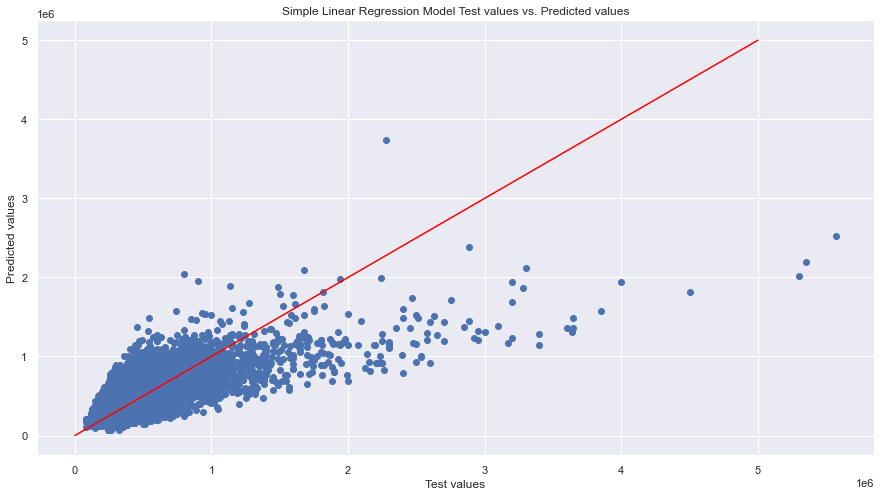

In [100]:
# Plot predictions

fig, ax = plt.subplots(figsize=(15,8))
_ = plt.scatter(y_test, y_pred_lr1)

# Add a line for perfect correlation

plt.plot([x for x in range(0,5000000)],[x for x in range(0,5000000)], color='red')

# Add labels and title

plt.xlabel('Test values')
plt.ylabel('Predicted values')
plt.title('Simple Linear Regression Model Test values vs. Predicted values')
plt.savefig('../reports/figures/simple_predict.png')
plt.show()

**The fit of this model is not very good. More features are needed for better prediction.**

### Multiple Linear Regression Model

**The remaining models will be regressed with the following features on price:**

In [101]:
list(X_train.columns)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'renovated',
 'basement',
 'view_binary',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98058',
 'zipcode_98059',
 'zipcode_98065',
 'zipcode_98070',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode

In [102]:
# Fit multiple linear regression model

lr2.fit(X_train, y_train)

# Generate predictions

y_pred_lr2 = lr2.predict(X_test)

In [103]:
# Print R2 score and root mean square errors for cross validation and test set

r2_score_lr2 = round(r2_score(y_test, y_pred_lr2), 8)
rmse_test_score_lr2 = round(mean_squared_error(y_test, y_pred_lr2, squared=False))
rmse_train_score_lr2 = round(-score_lr2["test_score"].mean())

print("Test set R2 score:          ", r2_score_lr2)
print("Test set RMSE:              ", rmse_test_score_lr2)
print("Mean validation set RMSE:   ", rmse_train_score_lr2)

Test set R2 score:           0.83233096
Test set RMSE:               155582
Mean validation set RMSE:    149124


**The R2 score and root mean square errors are improved significantly from the simple linear model.**

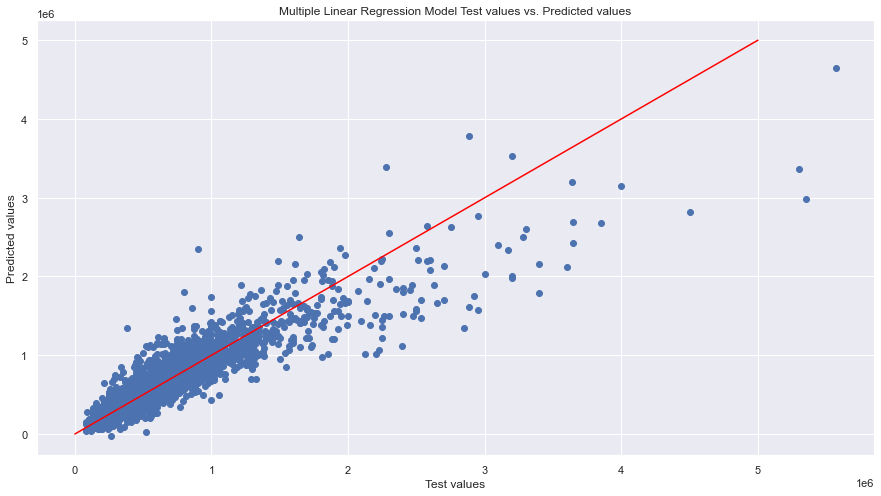

In [104]:
# Plot predictions

fig, ax = plt.subplots(figsize=(15,8))
_ = plt.scatter(y_test, y_pred_lr2)

# Add a line for perfect correlation

plt.plot([x for x in range(0,5000000)],[x for x in range(0,5000000)], color='red')

# Add labels and title

plt.xlabel('Test values')
plt.ylabel('Predicted values')
plt.title('Multiple Linear Regression Model Test values vs. Predicted values')
plt.savefig('../reports/figures/multiple_predict.png')
plt.show()

**The multiple linear regression model predictions are much better than the simple linear regression model. The best performance of the model is at lower values of the target variable, where most of the data is clustered.**  

### Ridge Regression Model

In [105]:
# Fit ridge regression model

ridge.fit(X_train, y_train)

# Generate predictions

y_pred_ridge = ridge.predict(X_test)

In [106]:
# Print R2 score and root mean square errors for cross validation and test set

r2_score_ridge = round(r2_score(y_test, y_pred_ridge), 8)
rmse_test_score_ridge = round(mean_squared_error(y_test, y_pred_ridge, squared=False))
rmse_train_score_ridge = round(-score_ridge["test_score"].mean())

print("Test set R2 score:          ", r2_score_ridge)
print("Test set RMSE:              ", rmse_test_score_ridge)
print("Mean validation set RMSE:   ", rmse_train_score_ridge)

Test set R2 score:           0.83193186
Test set RMSE:               155767
Mean validation set RMSE:    149253


**The ridge regression model performs nearly identically to the multiple linear regression model. Perhaps hyperparameter tuning will adjust the performance.**

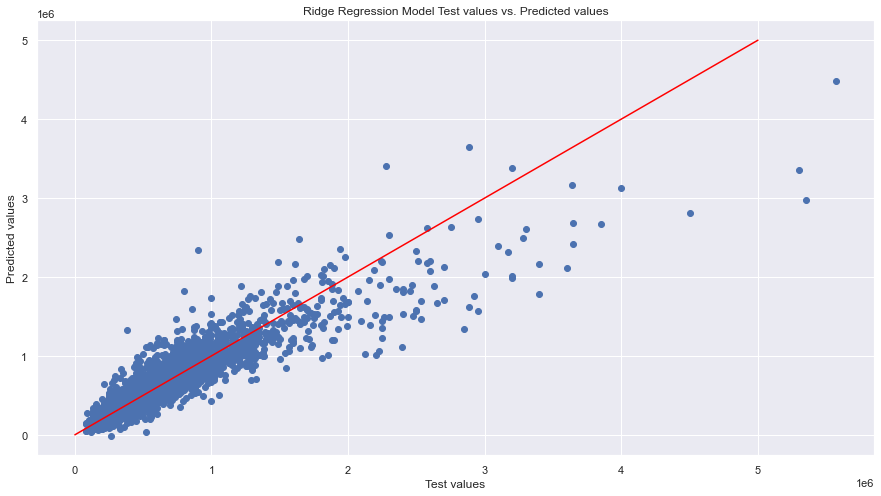

In [107]:
# Plot predictions

fig, ax = plt.subplots(figsize=(15,8))
_ = plt.scatter(y_test, y_pred_ridge)

# Add a line for perfect correlation

plt.plot([x for x in range(0,5000000)],[x for x in range(0,5000000)], color='red')

# Add labels and title

plt.xlabel('Test values')
plt.ylabel('Predicted values')
plt.title('Ridge Regression Model Test values vs. Predicted values')
plt.savefig('../reports/figures/ridge_predict.png')
plt.show()

### Random Forest Regression Model

In [108]:
# Fit random forest regression model

rf.fit(X_train, np.ravel(y_train))

# Generate predictions

y_pred_rf = rf.predict(X_test)

In [109]:
# Print R2 score and root mean square errors for cross validation and test set

r2_score_rf = round(r2_score(y_test, y_pred_rf), 8)
rmse_test_score_rf = round(mean_squared_error(y_test, y_pred_rf, squared=False))
rmse_train_score_rf = round(-score_rf["test_score"].mean())

print("Test set R2 score:          ", r2_score_rf)
print("Test set RMSE:              ", rmse_test_score_rf)
print("Mean validation set RMSE:   ", rmse_train_score_rf)

Test set R2 score:           0.79907189
Test set RMSE:               170315
Mean validation set RMSE:    148234


**The random forest regression model is worse at predicting the test set values than the multiple linear regression and ridge regression model, but it performs much better than simple linear regression.**

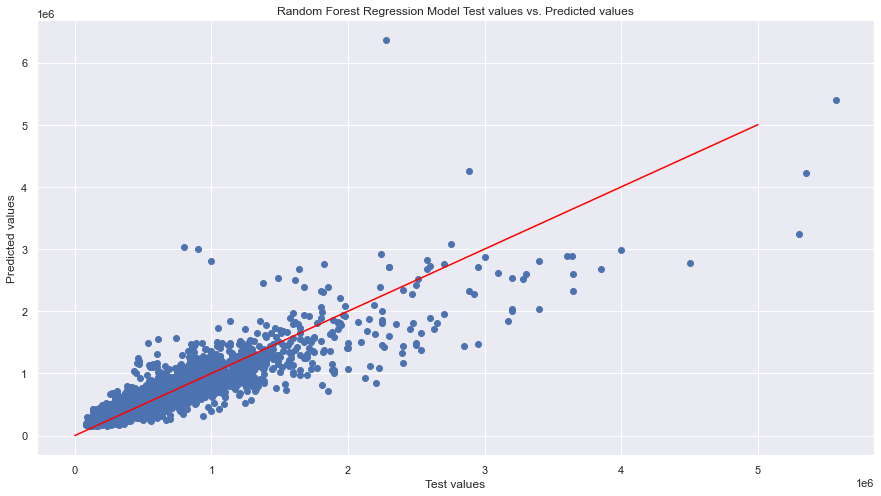

In [110]:
# Plot predictions

fig, ax = plt.subplots(figsize=(15,8))
_ = plt.scatter(y_test, y_pred_rf)

# Add a line for perfect correlation

plt.plot([x for x in range(0,5000000)],[x for x in range(0,5000000)], color='red')

# Add labels and title

plt.xlabel('Test values')
plt.ylabel('Predicted values')
plt.title('Random Forest Regression Model Test values vs. Predicted values')
plt.savefig('../reports/figures/rf_predict.png')
plt.show()

## Hyperparameter Tuning

### Ridge Regression Hyperparameter Tuning

In [111]:
# Create parameter grid

param = dict()
param['alpha'] = np.arange(0.1, 10.1, 0.1)

In [112]:
# Reinstantiate the model and set hyperparameter grid values to search

ridge_tune = Ridge()

In [113]:
# Create GridSearchCV object with parameter grid

grid = GridSearchCV(ridge_tune, param, scoring=scoring, n_jobs=-1, cv=cv)

In [114]:
# Fit GridSearchCV to training data

grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=42),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ])},
             scoring='neg_root_mean_squared_error')

In [115]:
# Summarize result

print('Best Score: %s' % grid.best_score_)
print('Best Hyperparameters: %s' % grid.best_params_)

Best Score: -149114.45709265332
Best Hyperparameters: {'alpha': 0.2}


In [116]:
# Reinstantiate the model with optimal hyperparameters

ridge_tune = Ridge(alpha=grid.best_params_['alpha'])

In [117]:
# Cross validate model

score_ridge_tune = cross_validate(ridge_tune, X_train, y_train, cv=5, scoring=scoring, return_estimator=True)

In [118]:
# Fit hyperparameter tuned ridge regression model

ridge_tune.fit(X_train, y_train)

# Generate predictions

y_pred_ridge_tune = ridge_tune.predict(X_test)

In [119]:
# Print R2 score and root mean square errors for cross validation and test set
r2_score_ridge_tune = round(r2_score(y_test, y_pred_ridge_tune), 8)
rmse_test_score_ridge_tune = round(mean_squared_error(y_test, y_pred_ridge_tune, squared=False))
rmse_train_score_ridge_tune = round(-score_ridge_tune["test_score"].mean())

print("Test set R2 score:          ", r2_score_ridge_tune)
print("Test set RMSE:              ", rmse_test_score_ridge_tune)
print("Mean validation set RMSE:   ", rmse_train_score_ridge_tune)

Test set R2 score:           0.83230862
Test set RMSE:               155592
Mean validation set RMSE:    149805


### Random Forest Regression Hyperparameter Tuning

In [120]:
# Reinstantiate the model and set hyperparameter grid values to search

rf_tune = RandomForestRegressor(random_state=1, n_jobs=-1)

param = { 
    'n_estimators': [200, 400, 600, 800],
    'max_features': ['sqrt','auto'],
    'max_depth': [10, 20, 30, 40, 50, None]
}

In [121]:
# Create GridSearchCV object with parameter grid and 10-fold cross validation

grid = GridSearchCV(rf_tune, param_grid=param, scoring=scoring, cv=5, n_jobs=-1)

In [122]:
# Fit GridSearchCV to training data

grid.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, None],
                         'max_features': ['sqrt', 'auto'],
                         'n_estimators': [200, 400, 600, 800]},
             scoring='neg_root_mean_squared_error')

In [123]:
# Summarize result

print('Best Score: %s' % grid.best_score_)
print('Best Hyperparameters: %s' % grid.best_params_)

Best Score: -148453.0394185498
Best Hyperparameters: {'max_depth': 50, 'max_features': 'auto', 'n_estimators': 800}


In [124]:
# Reinstantiate the model with optimal hyperparameters

rf_tune = RandomForestRegressor(max_depth=grid.best_params_['max_depth'], max_features=grid.best_params_['max_features'], n_estimators = grid.best_params_['n_estimators'], random_state=1, n_jobs=-1)

In [125]:
# Cross validate model

score_rf_tune = cross_validate(rf_tune, X_train, np.ravel(y_train), cv=5, scoring=scoring, return_estimator=True, n_jobs=-1)

In [126]:
# Fit hyperparameter tuned random forest regression model

rf_tune.fit(X_train, np.ravel(y_train))

# Generate predictions

y_pred_rf_tune = rf_tune.predict(X_test)

In [127]:
# Print R2 score and root mean square errors for cross validation and test set

r2_score_rf_tune = round(r2_score(y_test, y_pred_rf_tune), 8)
rmse_test_score_rf_tune = round(mean_squared_error(y_test, y_pred_rf_tune, squared=False))
rmse_train_score_rf_tune = round(-score_rf_tune["test_score"].mean())

print("Test set R2 score:          ", r2_score_rf_tune)
print("Test set RMSE:              ", rmse_test_score_rf_tune)
print("Mean validation set RMSE:   ", rmse_train_score_rf_tune)

Test set R2 score:           0.79998967
Test set RMSE:               169926
Mean validation set RMSE:    148453


**The random forest regression model tuning has yielded a slightly better performance than the default settings. Since the random forest regression model does not perform as well with the test data compared to ridge and multiple linear regression, additional tuning efforts will likely not be a productive exercise. The random forest regression also overfits the data compared to the linear regression models as shown by the wider discrepancy in scores between the validation and test sets.**

## Summary Table

In [128]:
# Make lists of model labels and scoring metrics

model_list = ['Simple Linear Regression','Multiple Linear Regression','Ridge Regression',
              'Ridge Regression (tuned)', 'Random Forest Regression', 'Random Forest Regression (tuned)']
scores_train = [rmse_train_score_lr1, rmse_train_score_lr2, rmse_train_score_ridge,
                rmse_train_score_ridge_tune, rmse_train_score_rf, rmse_train_score_rf_tune]
scores_test = [rmse_test_score_lr1, rmse_test_score_lr2, rmse_test_score_ridge,
                rmse_test_score_ridge_tune, rmse_test_score_rf, rmse_test_score_rf_tune]
r2_test = [r2_score_lr1, r2_score_lr2, r2_score_ridge, r2_score_ridge_tune, r2_score_rf, r2_score_rf_tune]

In [129]:
# Create DataFrame of scoring metrics

score_table = pd.DataFrame(list(zip(scores_train, scores_test, r2_test)),
                           columns =['Validation Set RMSE', 'Test Set RMSE', 'Test Set R2 Score'], index=model_list)

In [130]:
# View scoring metrics table sorted by Test Set RMSE

score_table.sort_values(by='Test Set RMSE')

,Validation Set RMSE,Test Set RMSE,Test Set R2 Score
Multiple Linear Regression,149124,155582,0.832331
Ridge Regression (tuned),149805,155592,0.832309
Ridge Regression,149253,155767,0.831932
Random Forest Regression (tuned),148453,169926,0.799990
Random Forest Regression,148234,170315,0.799072
Simple Linear Regression,256171,272965,0.483883


**Multiple Linear Regression and Ridge Regression are the best models. Random Forest Regression tends to overfit by comparison, as the gap between the validation set and test set errors are higher. Random Forest Regression is also more computationally intensive and less intuitive to interpret.**

### Feature Importances for Selected Model - Multiple Linear Regression

**What are the most important features in the model as determined by the scaled coefficent magnitude?**

In [131]:
# Copy X_train and X_test DataFrames for numeric normalization

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [132]:
# Normalize numeric columns to values between 0 and 1

numeric_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors']

num_X_train = X_train[numeric_columns]
num_X_test = X_test[numeric_columns]

# Instantiate MinMaxScaler object

scaler = MinMaxScaler()

# Fit and transform X_train. Use fitted model to transform X_test

X_train_scaled[numeric_columns] = scaler.fit_transform(num_X_train)
X_test_scaled[numeric_columns] = scaler.transform(num_X_test)

In [133]:
# Instantiate LinearRegression model for scaled data

scaled_model = LinearRegression()


# Fit model

scaled_model.fit(X_train_scaled, y_train)

# Create predictions

y_pred_scaled = scaled_model.predict(X_test_scaled)

In [134]:
# For comparison to non-scaled model - How does the scaled model perform on the test set?

r2_score_lr2 = round(r2_score(y_test, y_pred_scaled), 8)
rmse_test_score_lr2 = round(mean_squared_error(y_test, y_pred_scaled, squared=False))

print("Test set R2 score:          ", r2_score_lr2)
print("Test set RMSE:              ", rmse_test_score_lr2)

Test set R2 score:           0.83233096
Test set RMSE:               155582


**The scaled model test metrics are equivalent to the non-scaled model. The scaled model will now be analyzed for coefficient importance with all features now having a range between 0 and 1.**

In [135]:
# Create DataFrame of feature coefficient values

coefs = pd.DataFrame(data=list(scaled_model.coef_[0]), 
                     index=X.columns, columns=['coefficient_value'])

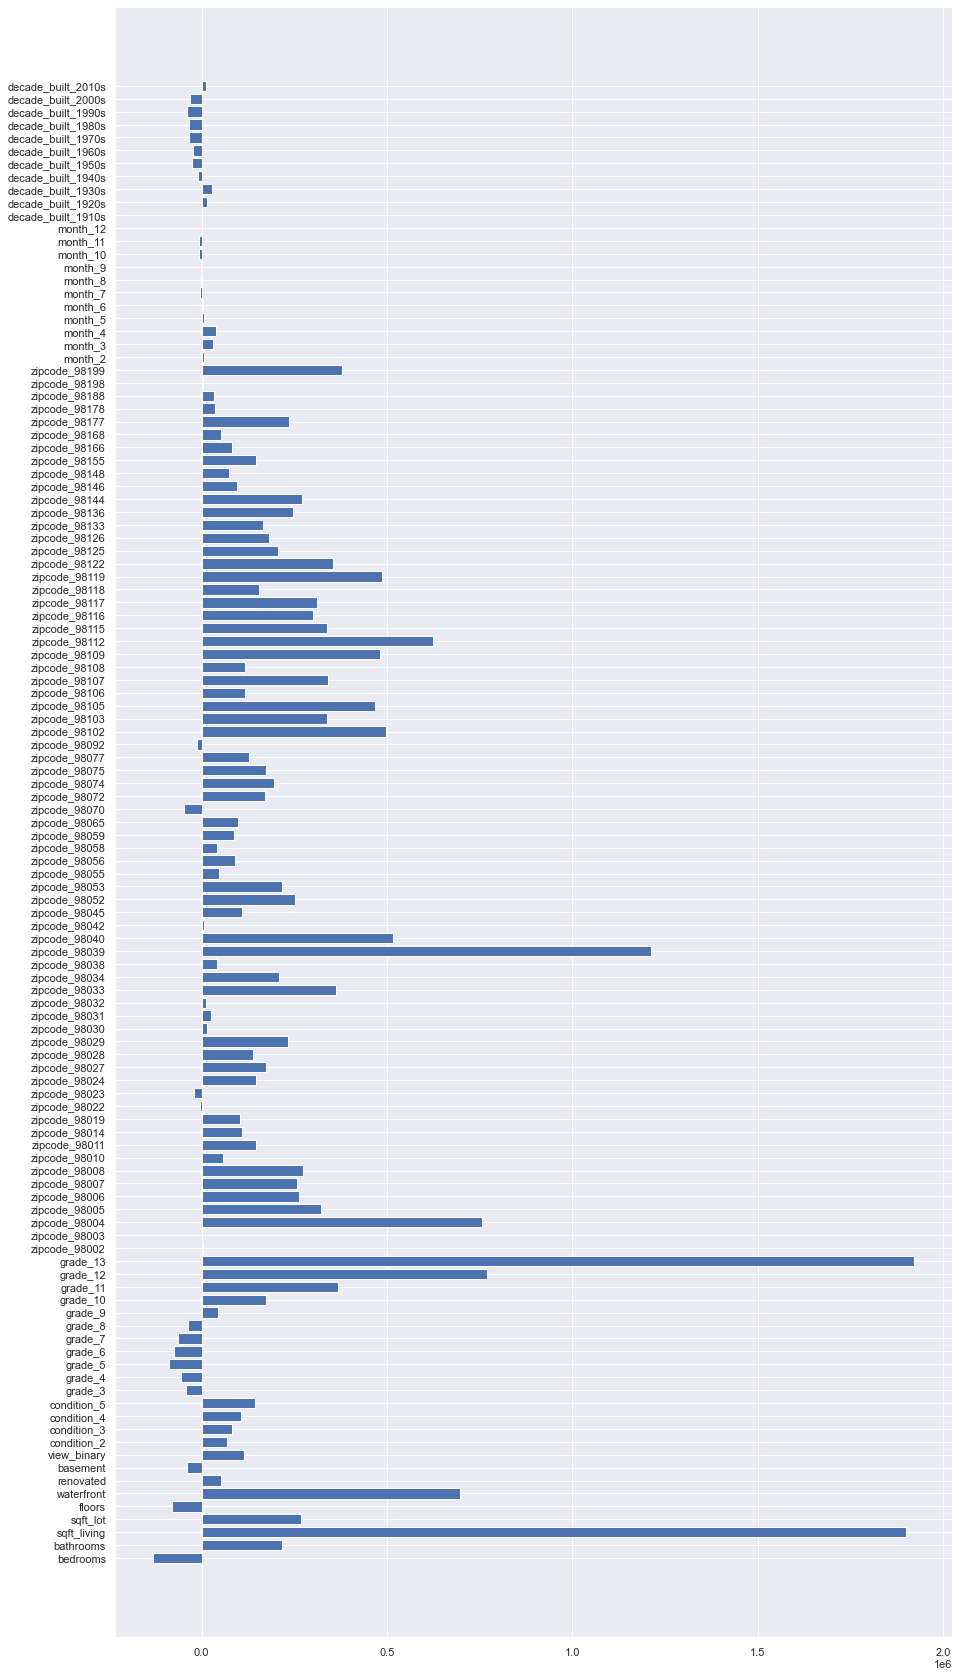

In [136]:
# plot feature importance

plt.subplots(figsize=(15,30))
plt.barh(X.columns, coefs['coefficient_value'])
plt.savefig('../reports/figures/feature_importance.png')
plt.show()

**The most important features that influence price according to the scaled model are high grade values (11-13), sqft_living, waterfront location, and Zip Code. The top five Zip Codes with the highest mean sale price are also the top five Zip Codes in feature importance.**

**When the house was built (decade_built bins) is of low importance, as is month sold. Whether or not a house was renovated or has a basement are also of low importance according to the model. Number of bathrooms has a moderate positive magnitude, while bedrooms is moderately negative.**

In [137]:
# View feature coefficients sorted descending by magnitude

coefs.reindex(coefs['coefficient_value'].abs().sort_values(ascending=False).index).head(40)

,coefficient_value
grade_13,1.922891e+06
sqft_living,1.899967e+06
zipcode_98039,1.212932e+06
grade_12,7.686535e+05
zipcode_98004,7.563797e+05
waterfront,6.965632e+05
zipcode_98112,6.228991e+05
zipcode_98040,5.164696e+05
zipcode_98102,4.971255e+05
zipcode_98119,4.868759e+05


In [138]:
# View least important features

coefs.reindex(coefs['coefficient_value'].abs().sort_values().index).head(40)

,coefficient_value
decade_built_1910s,740.888285
month_12,1219.259373
zipcode_98003,1344.830657
month_8,-2449.731945
month_9,-2833.272780
month_7,-3056.469928
zipcode_98002,3639.222371
month_6,4373.305314
zipcode_98022,-4481.933961
zipcode_98198,4558.286686


#### Numeric coefficients converted into original units

In [139]:
# Create DataFrame of scaled numeric features converted back to original units for interpretation

scaled_features = pd.DataFrame(data=coefs.loc[numeric_columns, 'coefficient_value'])

for i in range(len(scaled_features.index)):
    scaled_features.iloc[i] = scaled_features.iloc[i] * scaler.scale_[i]
    
scaled_features

,coefficient_value
bedrooms,-14418.992221
bathrooms,28870.336632
sqft_living,161.561801
sqft_lot,0.231053
floors,-32393.400983


**The negative coefficient of bedrooms is counter-intuitive. The bivariate plot of bedrooms vs. price shows a positive correlation up to 5-6 bedrooms, and a negative correlation above that. It seems these higher bedroom values could be confusing the interpretation of this feature.**

**Holding other variables constant, a one unit increase in number of bathrooms will result in a 28,870 increase in sale price. Each additional square foot of living area will increase the sale price by 162 dollars.**

## Conclusions

Multiple linear regression is a good approach for general price prediction for single family house sales over a large and diverse area such as King County. However, the root mean square error for the model of approximately $150,000 means that the model cannot be used for precise price prediction, especially at the lower end of the range of house sale prices. Still, the model may be useful to start the conversation on house pricing between realtors and their clients.

**Recommendations:**
    
- To maximize house sales in the future for a real estate firm in King County, the most important features to emphasize are:
    1. High building grade (11-13 in particular)
    2. Living area square footage
    3. Location within the county (zip code), particularly the area around downtown Seattle and to the east along Lake Washington. 
    4. Waterfront location
- Common features of lesser importance include Lot size and number of bathrooms, and number of bedrooms. The month of house sale and the age of the house are of low importance to sale price.

**Further Work:**

This large-scale model generated interesting insights, but it could be improved by creating smaller-scale models that focus on certain neighborhoods and more narrow price ranges. This could reduce the variance and error of the model price predictions, which increase as the house sale price increases.

In [140]:
# Write df, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, score_table to csv files

with open('../data/processed/df_edit.csv', 'w') as file:
    df.to_csv(file)

with open('../data/processed/X_train.csv', 'w') as file:
    X_train.to_csv(file)

with open('../data/processed/X_test.csv', 'w') as file:
    X_test.to_csv(file)

with open('../data/processed/y_train.csv', 'w') as file:
    y_train.to_csv(file)
    
with open('../data/processed/y_test.csv', 'w') as file:
    y_test.to_csv(file)
    
with open('../data/processed/X_train_scaled.csv', 'w') as file:
    X_train_scaled.to_csv(file)

with open('../data/processed/X_test_scaled.csv', 'w') as file:
    X_test_scaled.to_csv(file)
    
with open('../data/processed/score_table.csv', 'w') as file:
    score_table.to_csv(file)